# 1. Problema de Negócio

O conjunto de dados foi coletado por um 
período de 10 minutos por cerca de 5 meses. As condições de temperatura e 
umidade da casa foram monitoradas com uma rede de sensores sem fio ZigBee. 
Cada nó sem fio transmitia as condições de temperatura e umidade em torno 
de 3 min. Em seguida, a média dos dados foi calculada para períodos de 10 minutos. 

Os dados de energia foram registrados a cada 10 minutos com medidores de 
energia de barramento m. O tempo da estação meteorológica mais próxima do 
aeroporto (Aeroporto de Chievres, Bélgica) foi baixado de um conjunto de dados 
públicos do Reliable Prognosis (rp5.ru) e mesclado com os conjuntos de dados 
experimentais usando a coluna de data e hora. Duas variáveis aleatórias foram 
incluídas no conjunto de dados para testar os modelos de regressão e filtrar os 
atributos não preditivos (parâmetros).

O nosso objetivo é prever o uso de energia armazenado na variavel 'Appliances', dessa forma iremos construir um modelo de Regressão.

| Feature     | Descrição                                          | Unidade        |
|-------------|----------------------------------------------------|----------------|
| date        | Data no formato ano-mês-dia hora:minutos:segundos. |                |
| Appliances  | Consumo de energia. Variavel Target.               | Wh (Watt-Hora) |
| lights      | Consumo de energia de luminárias.                  | Wh (Watt-Hora) |
| T1          | Temperatura na Cozinha.                            | Celsius        |
| RH1         | Umidade Relativa na Cozinha.                       | %              |
| T2          | Temperatura na Sala de Estar.                      | Celsius        |
| RH2         | Umidade Relativa na Sala de Estar.                 | %              |
| T3          | Temperatura na Lavanderia.                         | Celsius        |
| RH3         | Umidade Relativa na Lavanderia.                    | %              |
| T4          | Temperatura no Escritório.                         | Celsius        |
| RH4         | Umidade Relativa no Escritório.                    | %              |
| T5          | Temperatura no Banheiro.                           | Celsius        |
| RH5         | Umidade Relativa no Banheiro.                      | %              |
| T6          | Temperatura Externa Lado Norte.                    | Celsius        |
| RH6         | Umidade Relativa Externa Lado Norte.               | %              |
| T7          | Temperatura na Sala de Passar Roupa.               | Celsius        |
| RH7         | Umidade Relativa na Sala de Passar Roupa.          | %              |
| T8          | Temperatura no Quarto do Adolescente.              | Celsius        |
| RH8         | Umidade Relativa no Quarto do Adolescente.         | %              |
| T9          | Temperatura no Quarto dos Pais.                    | Celsius        |
| RH9         | Umidade Relativa no Quarto dos Pais.               | %              |
| T_out       | Temperatura Externa.                               | Celsius        |
| Press_mm_hg | Pressão.                                           | mm/hg          |
| RH_out      | Umidade Relativa Externa.                          | %              |
| Windspeed   | Velocidade do Vento.                               | m/s            |
| Visibility  | Visibilidade.                                      | km             |
| Tdewpoint   | Ponto de Saturação.                                | Celsius        |
| rv1         | Variável Randômica.                                |                |
| rv2         | Variável Randômica.                                |                |
| NSM         | Segundos até a meioa noite                         |                |
| WeekStatus  | Indicativo de Dia da Semana ou Final de Semana.    |                |
| Day_of_week | Indicativo de Segunda à Domingo.                   |                |

# 2. Imports

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sweetviz as sv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap

from warnings import simplefilter
from matplotlib.colors import ListedColormap
from math import ceil
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from smogn import smoter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from holidays import Belgium
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, LinearSVR
from sklearn.feature_selection import RFE

In [131]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher" --iversions

Author: Herikc Brecher

statsmodels: 0.12.2
matplotlib : 3.3.4
sweetviz   : 2.1.3
seaborn    : 0.11.1
shap       : 0.39.0
pandas     : 1.2.4
numpy      : 1.19.5



## 2.1 Ambiente

In [3]:
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_theme()

In [4]:
seed_ = 194
np.random.seed(seed_)

# 3. Carregamento dos Dados

In [5]:
# Carregamento do dataset de treino e teste
dtTreino = pd.read_csv('data/training.csv')
dtTeste = pd.read_csv('data/testing.csv')

In [6]:
dtTreino.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4  2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  Press_mm_hg  RH_out  Windspeed  \
0  19.79  44.730000  19.000000  ...        733.5    92.0   7.000000   
1  19.79  44.790000  19.000000  ...        733.6    92.0   6.666667   
2  19.79  44.933333  18.926667  ...        733.7    92.0   6.333333   
3  19.79  45.000000  18.890000  ...        733.9    92.0   5.666667   
4  19.79  44.933333  18.890000  ...        734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1        rv2    NSM  WeekStatus  Day_of_week  
0   63.000000        5.3  13.275433  13.275433  61200     Weekday       Monday  
1   59.166667        5.2  18.606195  18.606195  61800     Weekday       Monday  
2   55.333333        5.1  28.642668  28.642668  62400     Weekday       Monday  
3   47.666667        4.9  10.084097  10.084097  63600     Weekday       Monday  
4   43.833333        4.8  44.919484  44.919484  64200     Weekday       Monday  

[5 rows x 32 columns]

In [7]:
dtTeste.head()

date  Appliances  lights         T1       RH_1         T2  \
0  2016-01-11 17:30:00          50      40  19.890000  46.066667  19.200000   
1  2016-01-11 18:00:00          60      50  19.890000  45.766667  19.200000   
2  2016-01-11 18:40:00         230      70  19.926667  45.863333  19.356667   
3  2016-01-11 18:50:00         580      60  20.066667  46.396667  19.426667   
4  2016-01-11 19:30:00         100      10  20.566667  53.893333  20.033333   

        RH_2     T3       RH_3     T4  ...  Press_mm_hg     RH_out  Windspeed  \
0  44.590000  19.79  45.000000  18.89  ...   733.800000  92.000000   6.000000   
1  44.500000  19.79  44.900000  18.89  ...   734.100000  92.000000   5.000000   
2  44.400000  19.79  44.900000  18.89  ...   734.366667  91.333333   5.666667   
3  44.400000  19.79  44.826667  19.00  ...   734.433333  91.166667   5.833333   
4  46.756667  20.10  48.466667  19.00  ...   734.850000  89.500000   6.000000   

   Visibility  Tdewpoint        rv1        rv2    NSM  WeekStatus  Day_of_week  
0        51.5   5.000000  45.410389  45.410389  63000     Weekday       Monday  
1        40.0   4.700000  47.233763  47.233763  64800     Weekday       Monday  
2        40.0   4.633333  10.298729  10.298729  67200     Weekday       Monday  
3        40.0   4.616667   8.827838   8.827838  67800     Weekday       Monday  
4        40.0   4.350000  24.884962  24.884962  70200     Weekday       Monday  

[5 rows x 32 columns]

In [8]:
dtFull = pd.concat([dtTreino, dtTeste], axis = 0)

In [9]:
dtFull.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4  2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  Press_mm_hg  RH_out  Windspeed  \
0  19.79  44.730000  19.000000  ...        733.5    92.0   7.000000   
1  19.79  44.790000  19.000000  ...        733.6    92.0   6.666667   
2  19.79  44.933333  18.926667  ...        733.7    92.0   6.333333   
3  19.79  45.000000  18.890000  ...        733.9    92.0   5.666667   
4  19.79  44.933333  18.890000  ...        734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1        rv2    NSM  WeekStatus  Day_of_week  
0   63.000000        5.3  13.275433  13.275433  61200     Weekday       Monday  
1   59.166667        5.2  18.606195  18.606195  61800     Weekday       Monday  
2   55.333333        5.1  28.642668  28.642668  62400     Weekday       Monday  
3   47.666667        4.9  10.084097  10.084097  63600     Weekday       Monday  
4   43.833333        4.8  44.919484  44.919484  64200     Weekday       Monday  

[5 rows x 32 columns]

In [10]:
print(dtTreino.shape, dtTeste.shape, dtFull.shape)

(14803, 32) (4932, 32) (19735, 32)


# 4. Analise Exploratoria

In [11]:
dtFull.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4  2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  Press_mm_hg  RH_out  Windspeed  \
0  19.79  44.730000  19.000000  ...        733.5    92.0   7.000000   
1  19.79  44.790000  19.000000  ...        733.6    92.0   6.666667   
2  19.79  44.933333  18.926667  ...        733.7    92.0   6.333333   
3  19.79  45.000000  18.890000  ...        733.9    92.0   5.666667   
4  19.79  44.933333  18.890000  ...        734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1        rv2    NSM  WeekStatus  Day_of_week  
0   63.000000        5.3  13.275433  13.275433  61200     Weekday       Monday  
1   59.166667        5.2  18.606195  18.606195  61800     Weekday       Monday  
2   55.333333        5.1  28.642668  28.642668  62400     Weekday       Monday  
3   47.666667        4.9  10.084097  10.084097  63600     Weekday       Monday  
4   43.833333        4.8  44.919484  44.919484  64200     Weekday       Monday  

[5 rows x 32 columns]

Possuimos ao todo 19375 observações, unindo o conjunto de treino e teste.

In [12]:
dtFull.describe()

Appliances        lights            T1          RH_1            T2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875     21.686571     40.259739     20.341219   
std      102.524891      7.935988      1.606066      3.979299      2.192974   
min       10.000000      0.000000     16.790000     27.023333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max     1080.000000     70.000000     26.260000     63.360000     29.856667   

               RH_2            T3          RH_3            T4          RH_4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.420420     22.267611     39.242500     20.855335     39.026904   
std        4.069813      2.006111      3.254576      2.042884      4.341321   
min       20.463333     17.200000     28.766667     15.100000     27.660000   
25%       37.900000     20.790000     36.900000     19.530000     35.530000   
50%       40.500000     22.100000     38.530000     20.666667     38.400000   
75%       43.260000     23.290000     41.760000     22.100000     42.156667   
max       56.026667     29.236000     50.163333     26.200000     51.090000   

       ...          RH_9         T_out   Press_mm_hg        RH_out  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...     41.552401      7.411665    755.522602     79.750418   
std    ...      4.151497      5.317409      7.399441     14.901088   
min    ...     29.166667     -5.000000    729.300000     24.000000   
25%    ...     38.500000      3.666667    750.933333     70.333333   
50%    ...     40.900000      6.916667    756.100000     83.666667   
75%    ...     44.338095     10.408333    760.933333     91.666667   
max    ...     53.326667     26.100000    772.300000    100.000000   

          Windspeed    Visibility     Tdewpoint           rv1           rv2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean       4.039752     38.330834      3.760707     24.988033     24.988033   
std        2.451221     11.794719      4.194648     14.496634     14.496634   
min        0.000000      1.000000     -6.600000      0.005322      0.005322   
25%        2.000000     29.000000      0.900000     12.497889     12.497889   
50%        3.666667     40.000000      3.433333     24.897653     24.897653   
75%        5.500000     40.000000      6.566667     37.583769     37.583769   
max       14.000000     66.000000     15.500000     49.996530     49.996530   

                NSM  
count  19735.000000  
mean   42907.129465  
std    24940.020831  
min        0.000000  
25%    21600.000000  
50%    43200.000000  
75%    64200.000000  
max    85800.000000  

[8 rows x 29 columns]

A unica feature que aparenta estar no formato errado é a coluna 'Date', essa que é 'datetime' foi carregada como 'object'.

In [13]:
dtFull.dtypes

date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
NSM              int64
WeekStatus      object
Day_of_week     object
dtype: object

In [14]:
# Copiando para um dataset onde iremos processar os dados
dtProcessado = dtFull.copy()

# Convertendo a coluna 'date' para 'datetime'
dtProcessado['date'] = pd.to_datetime(dtProcessado['date'], format='%Y-%m-%d %H:%M:%S')

In [15]:
dtProcessado.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
rv1                   float64
rv2                   float64
NSM                     int64
WeekStatus             object
Day_of_week            object
dtype: object

Agora os dados estão no formato correto, e não tivemos perda de informação.

In [16]:
dtProcessado.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4 2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  Press_mm_hg  RH_out  Windspeed  \
0  19.79  44.730000  19.000000  ...        733.5    92.0   7.000000   
1  19.79  44.790000  19.000000  ...        733.6    92.0   6.666667   
2  19.79  44.933333  18.926667  ...        733.7    92.0   6.333333   
3  19.79  45.000000  18.890000  ...        733.9    92.0   5.666667   
4  19.79  44.933333  18.890000  ...        734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1        rv2    NSM  WeekStatus  Day_of_week  
0   63.000000        5.3  13.275433  13.275433  61200     Weekday       Monday  
1   59.166667        5.2  18.606195  18.606195  61800     Weekday       Monday  
2   55.333333        5.1  28.642668  28.642668  62400     Weekday       Monday  
3   47.666667        4.9  10.084097  10.084097  63600     Weekday       Monday  
4   43.833333        4.8  44.919484  44.919484  64200     Weekday       Monday  

[5 rows x 32 columns]

In [17]:
# Verificando se possui valor missing/NA
print(dtProcessado.isna().sum())

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
NSM            0
WeekStatus     0
Day_of_week    0
dtype: int64


Colunas como 'date', 'rv1' e 'rv2' possuem valores unicos para cada observação, sendo 1:1. Iremos verificar depois se essas informações são relevantes para o modelo, pois isso pode causar problemas.

In [18]:
# Verificando valores unicos
print(dtProcessado.nunique())

date           19735
Appliances        92
lights             8
T1               722
RH_1            2547
T2              1650
RH_2            3376
T3              1426
RH_3            2618
T4              1390
RH_4            2987
T5              2263
RH_5            7571
T6              4446
RH_6            9709
T7              1955
RH_7            5891
T8              2228
RH_8            6649
T9               924
RH_9            3388
T_out           1730
Press_mm_hg     2189
RH_out           566
Windspeed        189
Visibility       413
Tdewpoint       1409
rv1            19735
rv2            19735
NSM              144
WeekStatus         2
Day_of_week        7
dtype: int64


In [19]:
# Verificando se possui valores duplicados
print(sum(dtProcessado.duplicated()))

0


Para melhor interpretação dos dados, iremos separa eles em variaveis qualitativas e quantitativas.

In [20]:
qualitativas = ['WeekStatus', 'Day_of_week']
quantitativas = dtProcessado.drop(['WeekStatus', 'Day_of_week', 'date'], axis = 1).columns

In [21]:
dtProcessado[qualitativas].head()

WeekStatus Day_of_week
0    Weekday      Monday
1    Weekday      Monday
2    Weekday      Monday
3    Weekday      Monday
4    Weekday      Monday

In [22]:
dtProcessado[quantitativas].head()

Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   
3          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000   
4          50      40  19.89  46.026667  19.2  44.500000  19.79  44.933333   

          T4       RH_4  ...   RH_9     T_out  Press_mm_hg  RH_out  Windspeed  \
0  19.000000  45.566667  ...  45.53  6.600000        733.5    92.0   7.000000   
1  19.000000  45.992500  ...  45.56  6.483333        733.6    92.0   6.666667   
2  18.926667  45.890000  ...  45.50  6.366667        733.7    92.0   6.333333   
3  18.890000  45.530000  ...  45.40  6.133333        733.9    92.0   5.666667   
4  18.890000  45.730000  ...  45.29  6.016667        734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1        rv2    NSM  
0   63.000000        5.3  13.275433  13.275433  61200  
1   59.166667        5.2  18.606195  18.606195  61800  
2   55.333333        5.1  28.642668  28.642668  62400  
3   47.666667        4.9  10.084097  10.084097  63600  
4   43.833333        4.8  44.919484  44.919484  64200  

[5 rows x 29 columns]

# 4.2 Geração de plots e insights

Analisando o grafico abaixo é perceptivel que o consumo de energia nos 'Weekend' são proporcionais aos 'Weekday'. Já que a 'Weekday' representa exatatemente 28.5% de uma semana. Por acaso esse também é o valor do consumo de energia em %.

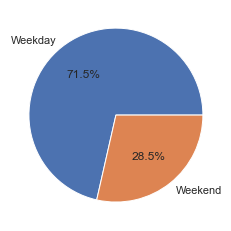

In [23]:
# Consumo de energia entre dias da semana e finais de semana
plt.pie(dtProcessado.groupby('WeekStatus').sum()['Appliances'], labels = ['Weekday', 'Weekend'], autopct = '%1.1f%%')
plt.show()

É perceptivel que ao longo do periodo da coleta dos dados mantemos oscilações comuns no consumo de energia, provavel que se de por eventos climaticos ao longo do periodo.

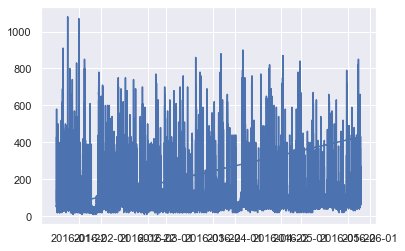

In [24]:
plt.plot(dtProcessado['date'], dtProcessado['Appliances'])

In [25]:
def scatter_plot_conjunto(data, columns, target):
    # Definindo range de Y
    y_range = [data[target].min(), data[target].max()]
    
    for column in columns:
        if target != column:
            # Definindo range de X
            x_range = [data[column].min(), data[column].max()]
            
            # Scatter plot de X e Y
            scatter_plot = data.plot(kind = 'scatter', x = column, y = target, xlim = x_range, ylim = y_range,\
                                    c = ['black'])
            
            # Traçar linha da media de X e Y
            meanX = scatter_plot.plot(x_range, [data[target].mean(), data[target].mean()], '--', color = 'red', linewidth = 1)
            meanY = scatter_plot.plot([data[column].mean(), data[column].mean()], y_range, '--', color = 'red', linewidth = 1)

É perceptivel que as variaveis 'T*' como 'T1', 'T2'... possuem baixa correlação com a variavel target. Onde possuimos concentrações maiores para valores médios, porém ao aumentarem ou diminuirem muito passam a diminuir a 'Appliances'. Já variaveis 'RH_*' possuem uma correlação um pouco maior.

C:\Users\herik\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


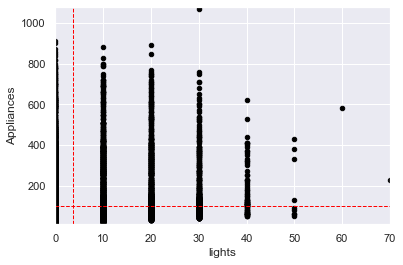

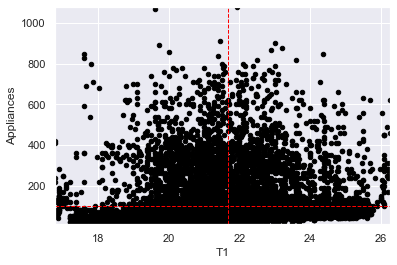

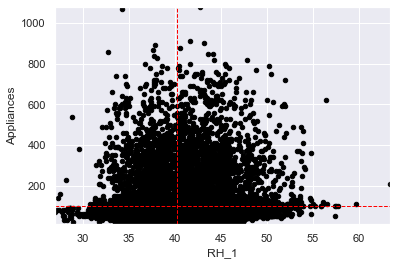

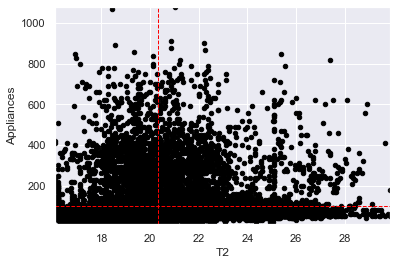

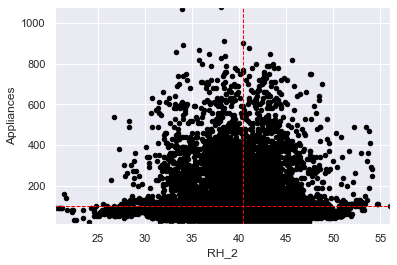

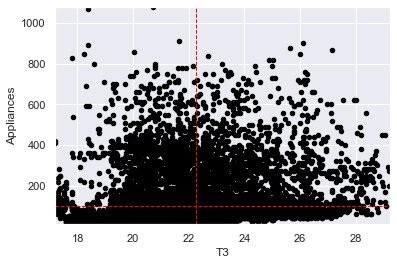

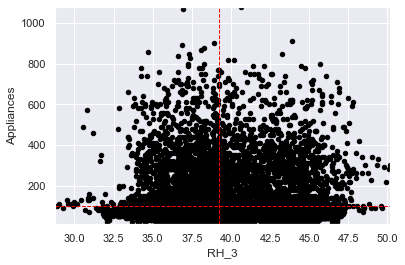

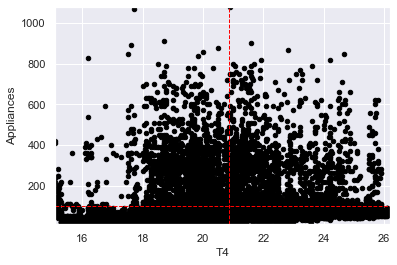

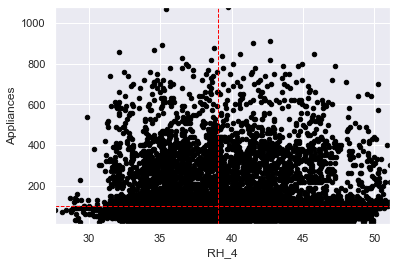

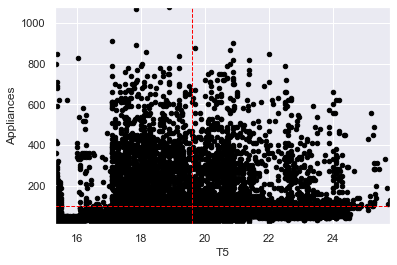

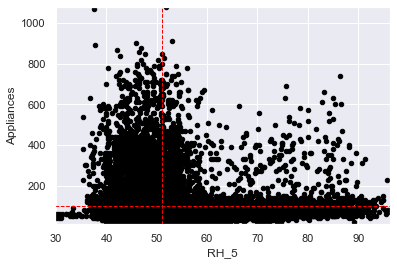

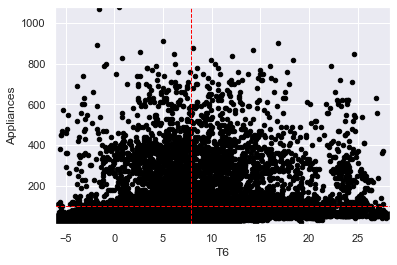

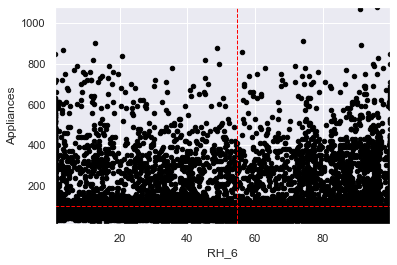

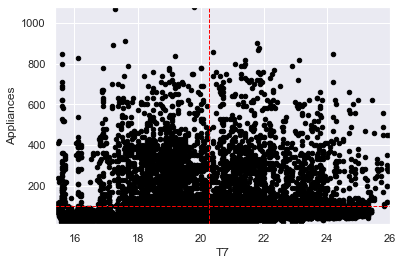

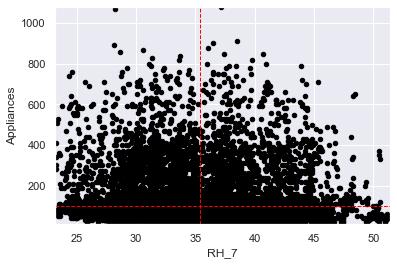

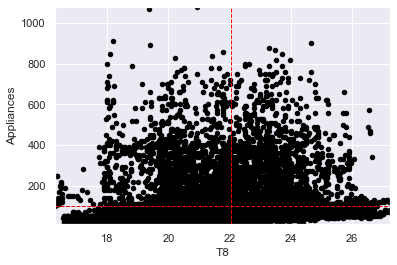

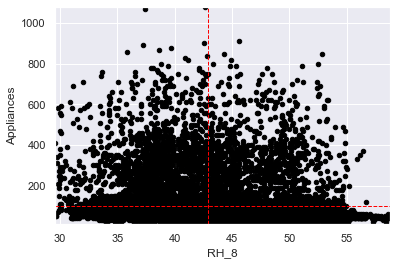

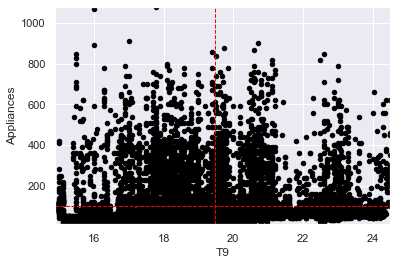

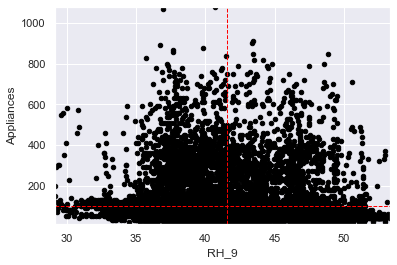

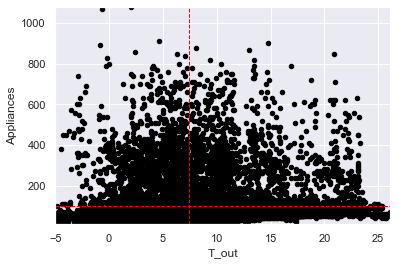

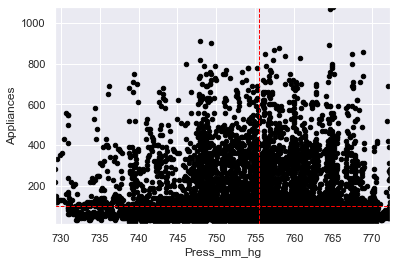

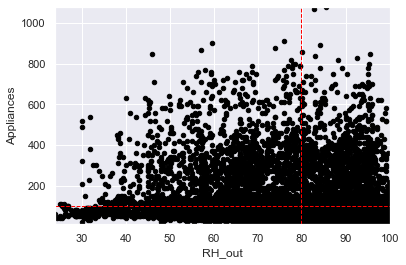

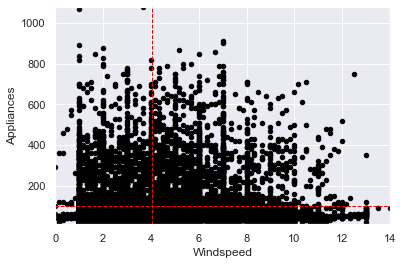

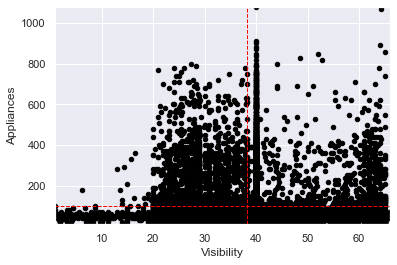

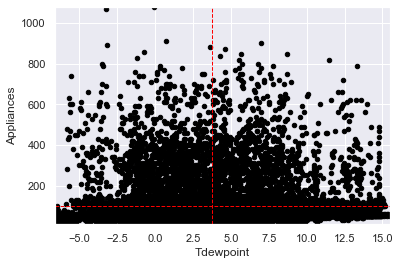

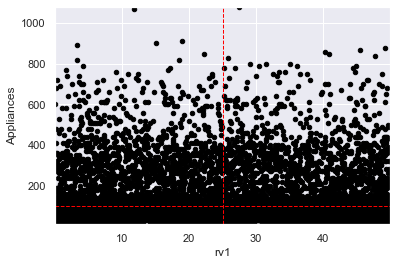

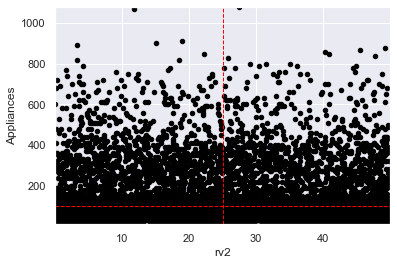

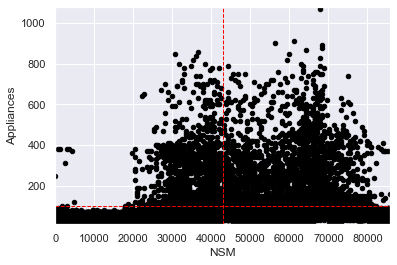

In [26]:
scatter_plot_conjunto(dtProcessado, quantitativas, 'Appliances')

## 4.3 Distribuição dos Dados

Iremos verificar se os nossos dados possuem uma distribuição Gaussiana ou não. Dessa forma iremos entender quais metodos estatisticos utilizar. Distribuições Gaussianas utilizam de métodos estatisticos paramétricos. Já o contrário utiliza de métodos estatisticos não paramétricos. É importante entender qual método utilizar para não termos uma vissão errada sobre os dados.

In [27]:
def quantil_quantil_teste(data, columns):
    
    for col in columns:
        print(col)
        qqplot(data[col], line = 's')
        plt.show()

Olhando os graficos abaixo, possuimos algumas variaveis que não seguem a reta Gaussiana, indicando dados não normalizados, porém para termos certeza, iremos trazer isso para uma representação numerica, onde podemos ter uma maior certeza.

Appliances


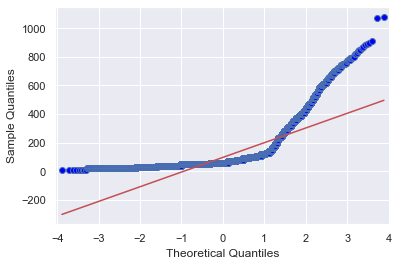

lights


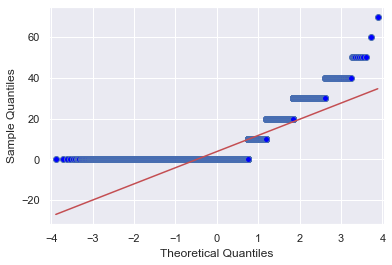

T1


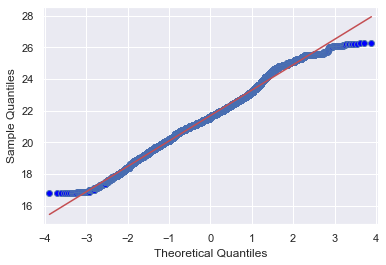

RH_1


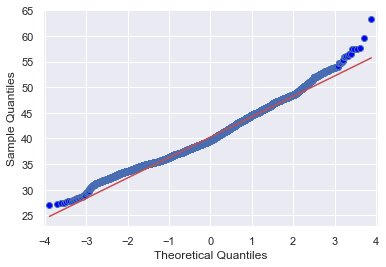

T2


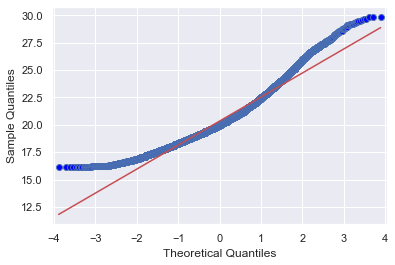

RH_2


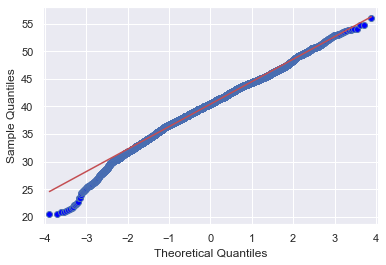

T3


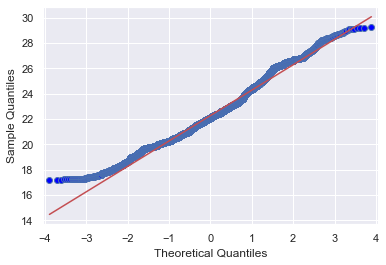

RH_3


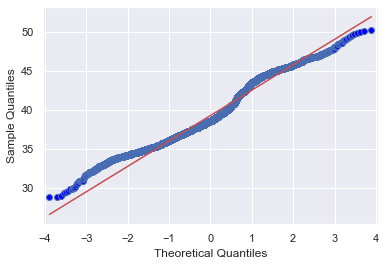

T4


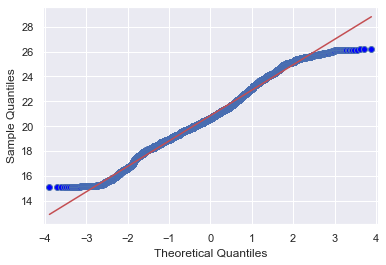

RH_4


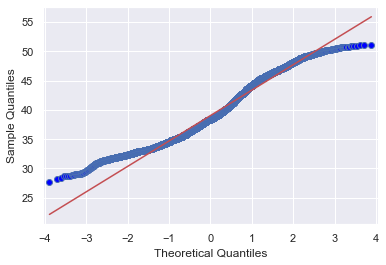

T5


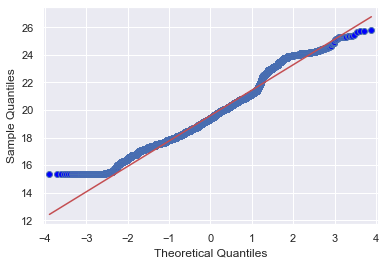

RH_5


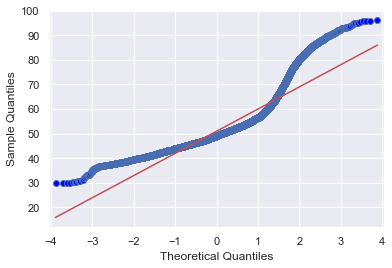

T6


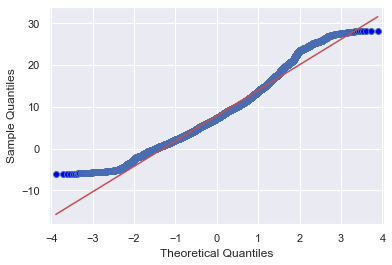

RH_6


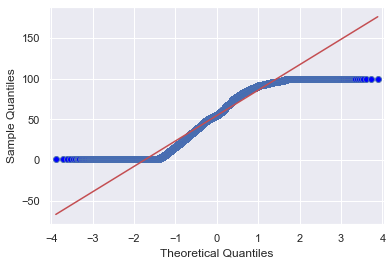

T7


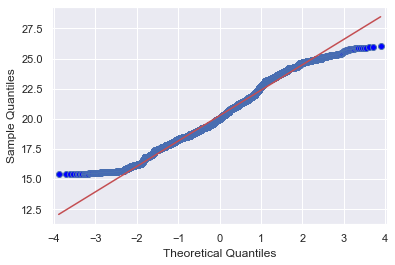

RH_7


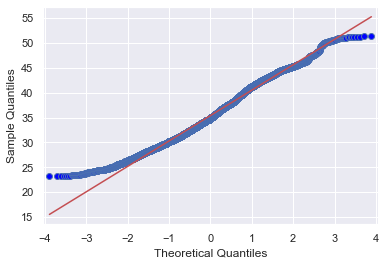

T8


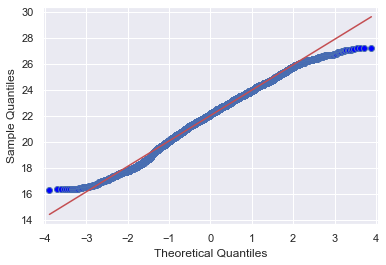

RH_8


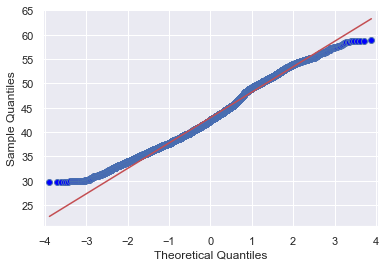

T9


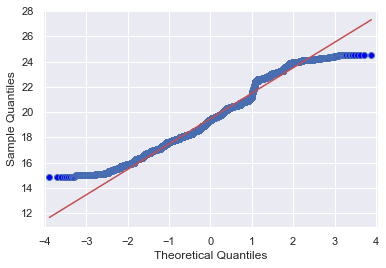

RH_9


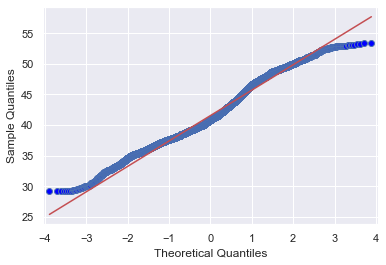

T_out


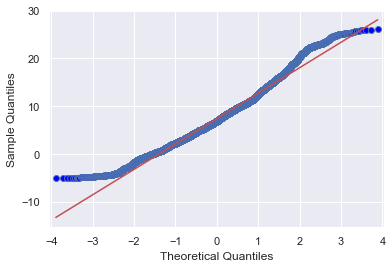

Press_mm_hg


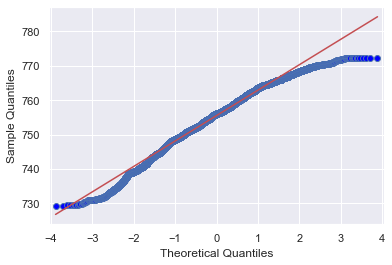

RH_out


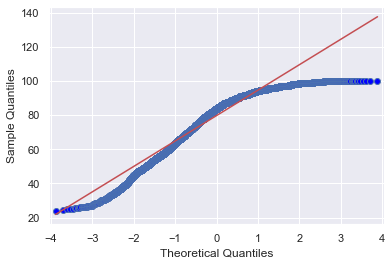

Windspeed


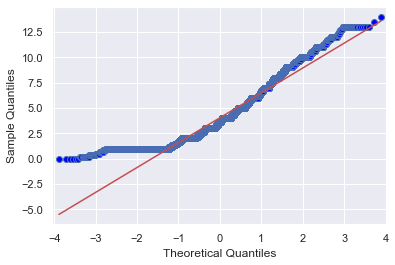

Visibility


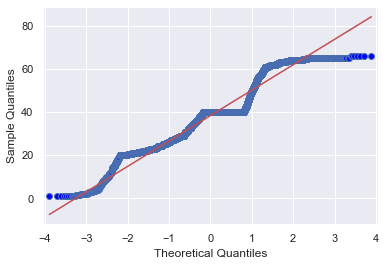

Tdewpoint


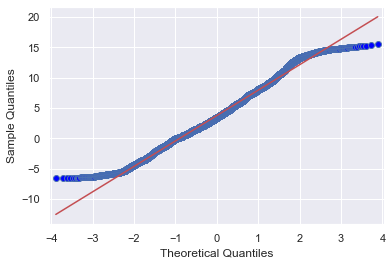

rv1


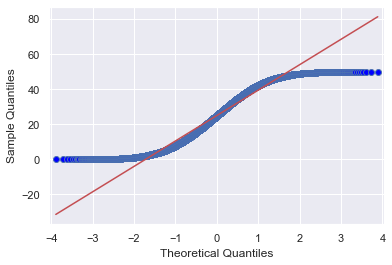

rv2


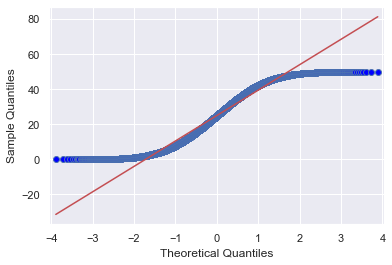

NSM


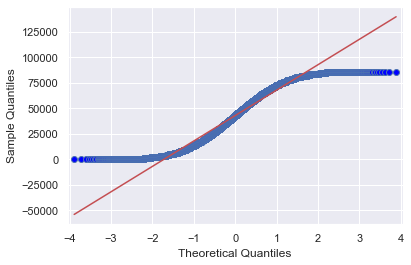

In [28]:
quantil_quantil_teste(dtProcessado, quantitativas)

In [29]:
def testes_gaussianos(data, columns, teste):
    
    for i, col in enumerate(columns):
        print('Teste para a variavel', col)
        alpha = 0.05
        
        if teste == 'shapiro':
            stat, p = shapiro(data[col])
        elif teste == 'normal':
            stat, p = normaltest(data[col])           
        elif teste == 'anderson':
            resultado = anderson(data[col])
            print('Stats: %.4f' % resultado.statistic)
            
            for j in range(len(resultado.critical_values)):
                sl, cv = resultado.significance_level[j], resultado.critical_values[j]
                
                if resultado.statistic < cv:
                    print('Significancia = %.4f, Valor Critico = %.4f, os dados parecem Gaussianos. Falha ao rejeitar H0.' % (sl, cv))
                else:
                    print('Significancia = %.4f, Valor Critico = %.4f, os dados não parecem Gaussianos. H0 rejeitado.' % (sl, cv))
            
        if teste != 'anderson':         
            print('Stat = ', round(stat, 4))
            print('p-value = ', round(p, 4))
            #print('Stats = %4.f, p = %4.f' % (stat, p))

            if p > alpha:
                print('Os dados parecem Gaussianos. Falha ao rejeitar H0.')
            else:
                print('Os dados não parecem Gaussianos. H0 rejeitado.')
            
        print('\n')

# 4.3.1 Teste normal de D'Agostino

O teste Normal de D'Agostino avalia se os dados são Gaussianos utilizando estatisticas resumidas como: Curtose e Skew.

Aparentemente os nossos dados não seguem o comportamento Gaussiano, dessa forma iremos ter que tomar medidas estatisticas para amenizar o impacto na hora da modelagem preditiva.

In [30]:
testes_gaussianos(dtProcessado, quantitativas, teste = 'normal')

Teste para a variavel Appliances
Stat =  14008.9202
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel lights
Stat =  8437.425
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel T1
Stat =  66.3657
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel RH_1
Stat =  657.2555
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel T2
Stat =  2300.1745
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel RH_2
Stat =  442.0018
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel T3
Stat =  610.1817
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel RH_3
Stat =  1238.9214
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel T4
Stat =  95.3642
p-value =  0.0
Os dados não parecem Gaussianos. H0 rejeitado.


Teste para a variavel RH_4

Analisando abaixo o boxplot das variaveis quantitativas, percebemos que algumas variaveis possuem muitos outliers e irão necessitar um tratamento.

Sendo alguas delas: 'Appliances', 'T1', 'RH_1', 'Visibility', 'RH_5'. Sendo alguns outliers somente para valores maximos e outros para valores minimos.

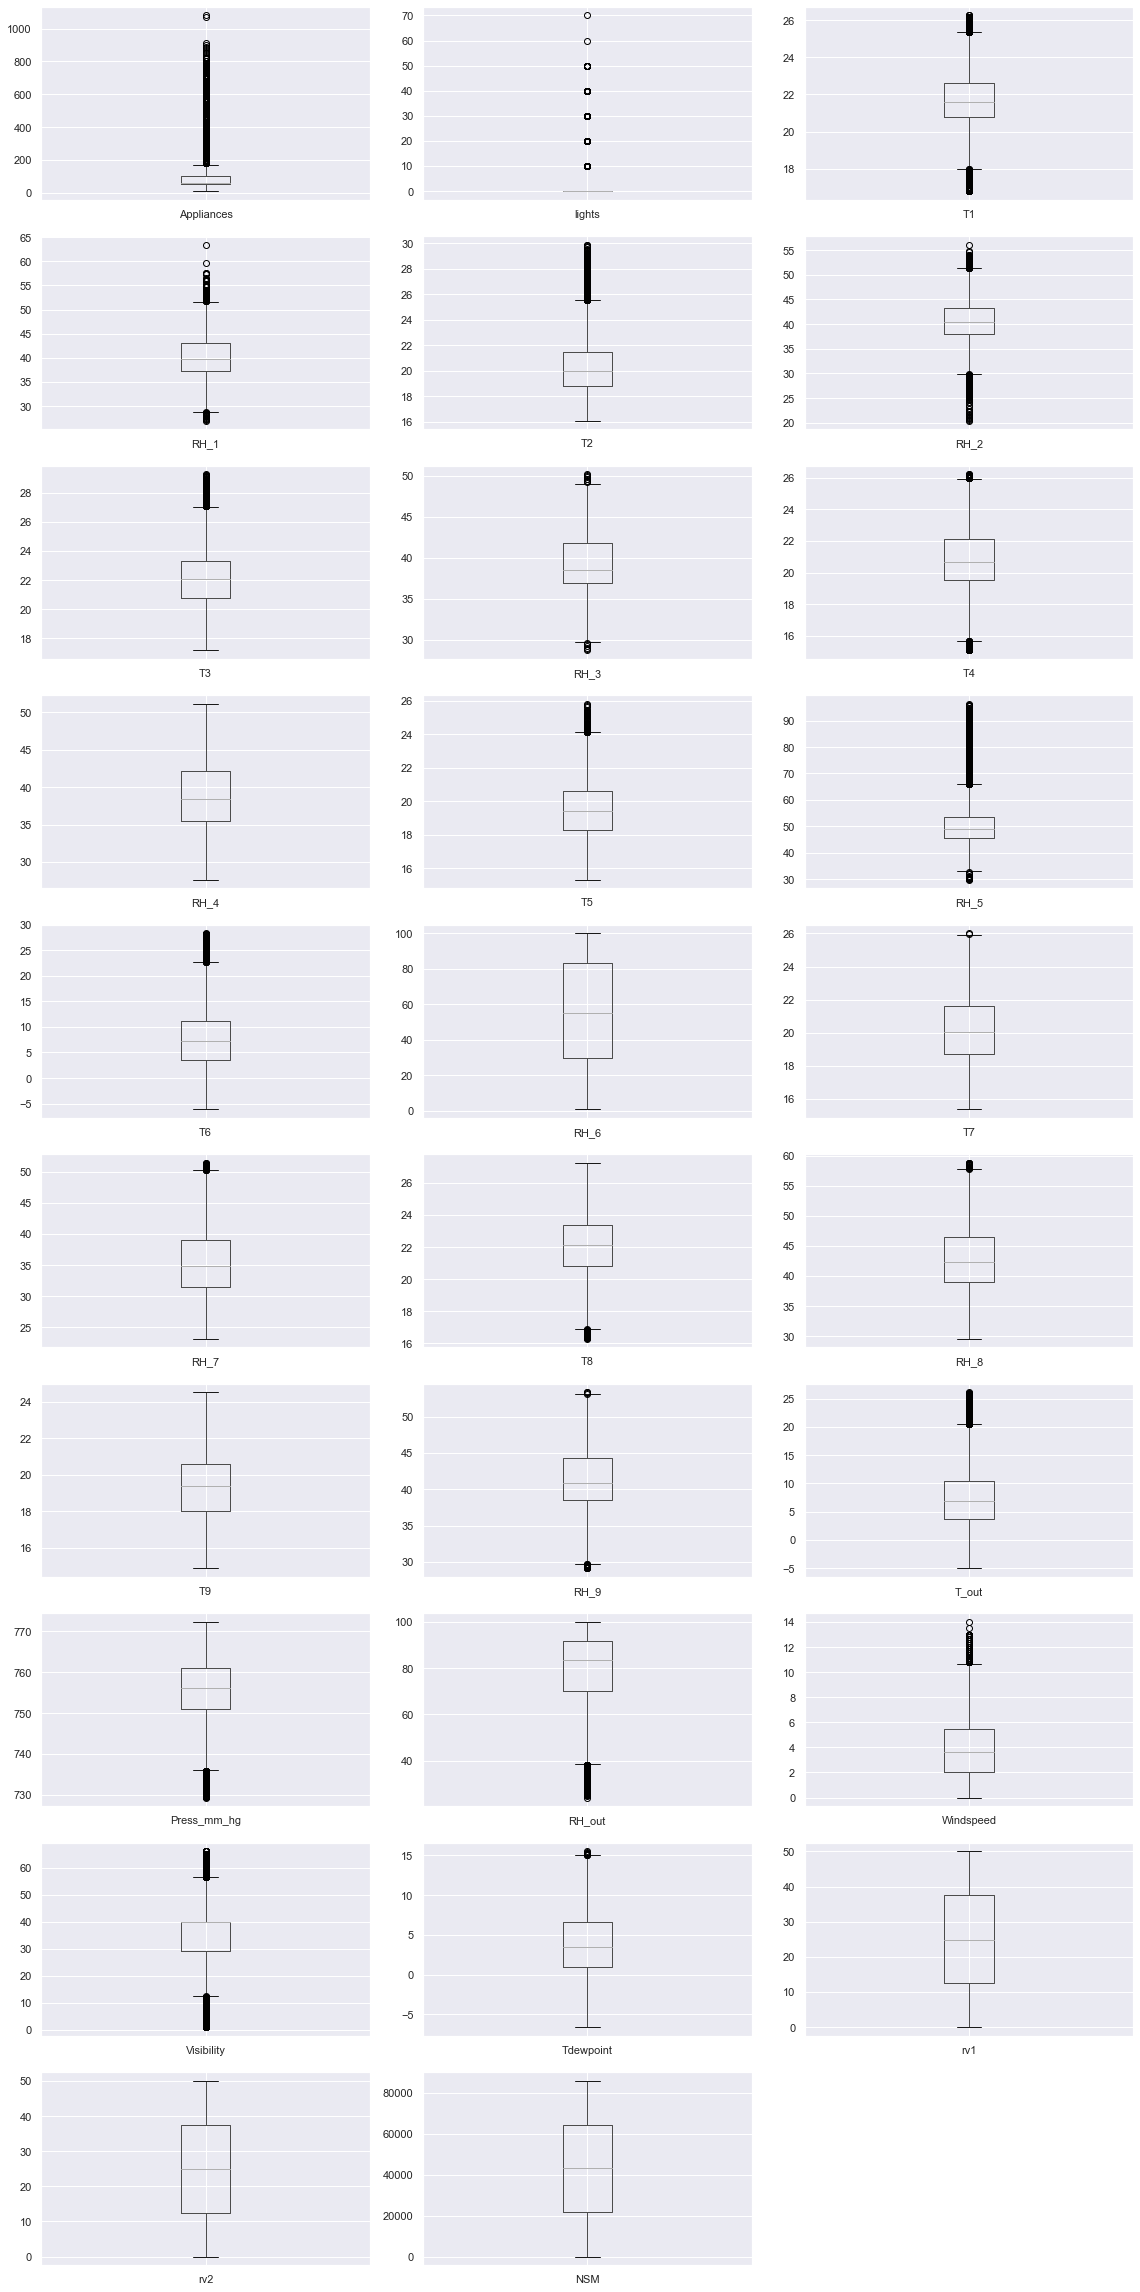

In [31]:
# Plot para variaveis quantitativas

fig = plt.figure(figsize = (16, 32))

for i, col in enumerate(quantitativas):
    plt.subplot(10, 3, i + 1)
    dtProcessado.boxplot(col)
    plt.tight_layout()

Visualizando rapidamente o heatmap, percebemos que existem valores muito proximo de preto e outros muito proximo de branco, valores esses fora da diagonal principal, indicando fortes indicios de multicolinearidade, o que para modelos de regressão são prejudiciais. 

Um segundo ponto são as variaveis 'rv1' e 'rv2' que possuem correlação 1, de acordo com o nosso dicionario de dados essas variaveis são randomicas, então irão ser removidas do dataset de qualquer maneira. Já o NSM é uma variavel sequencial, que também irá ser removida.

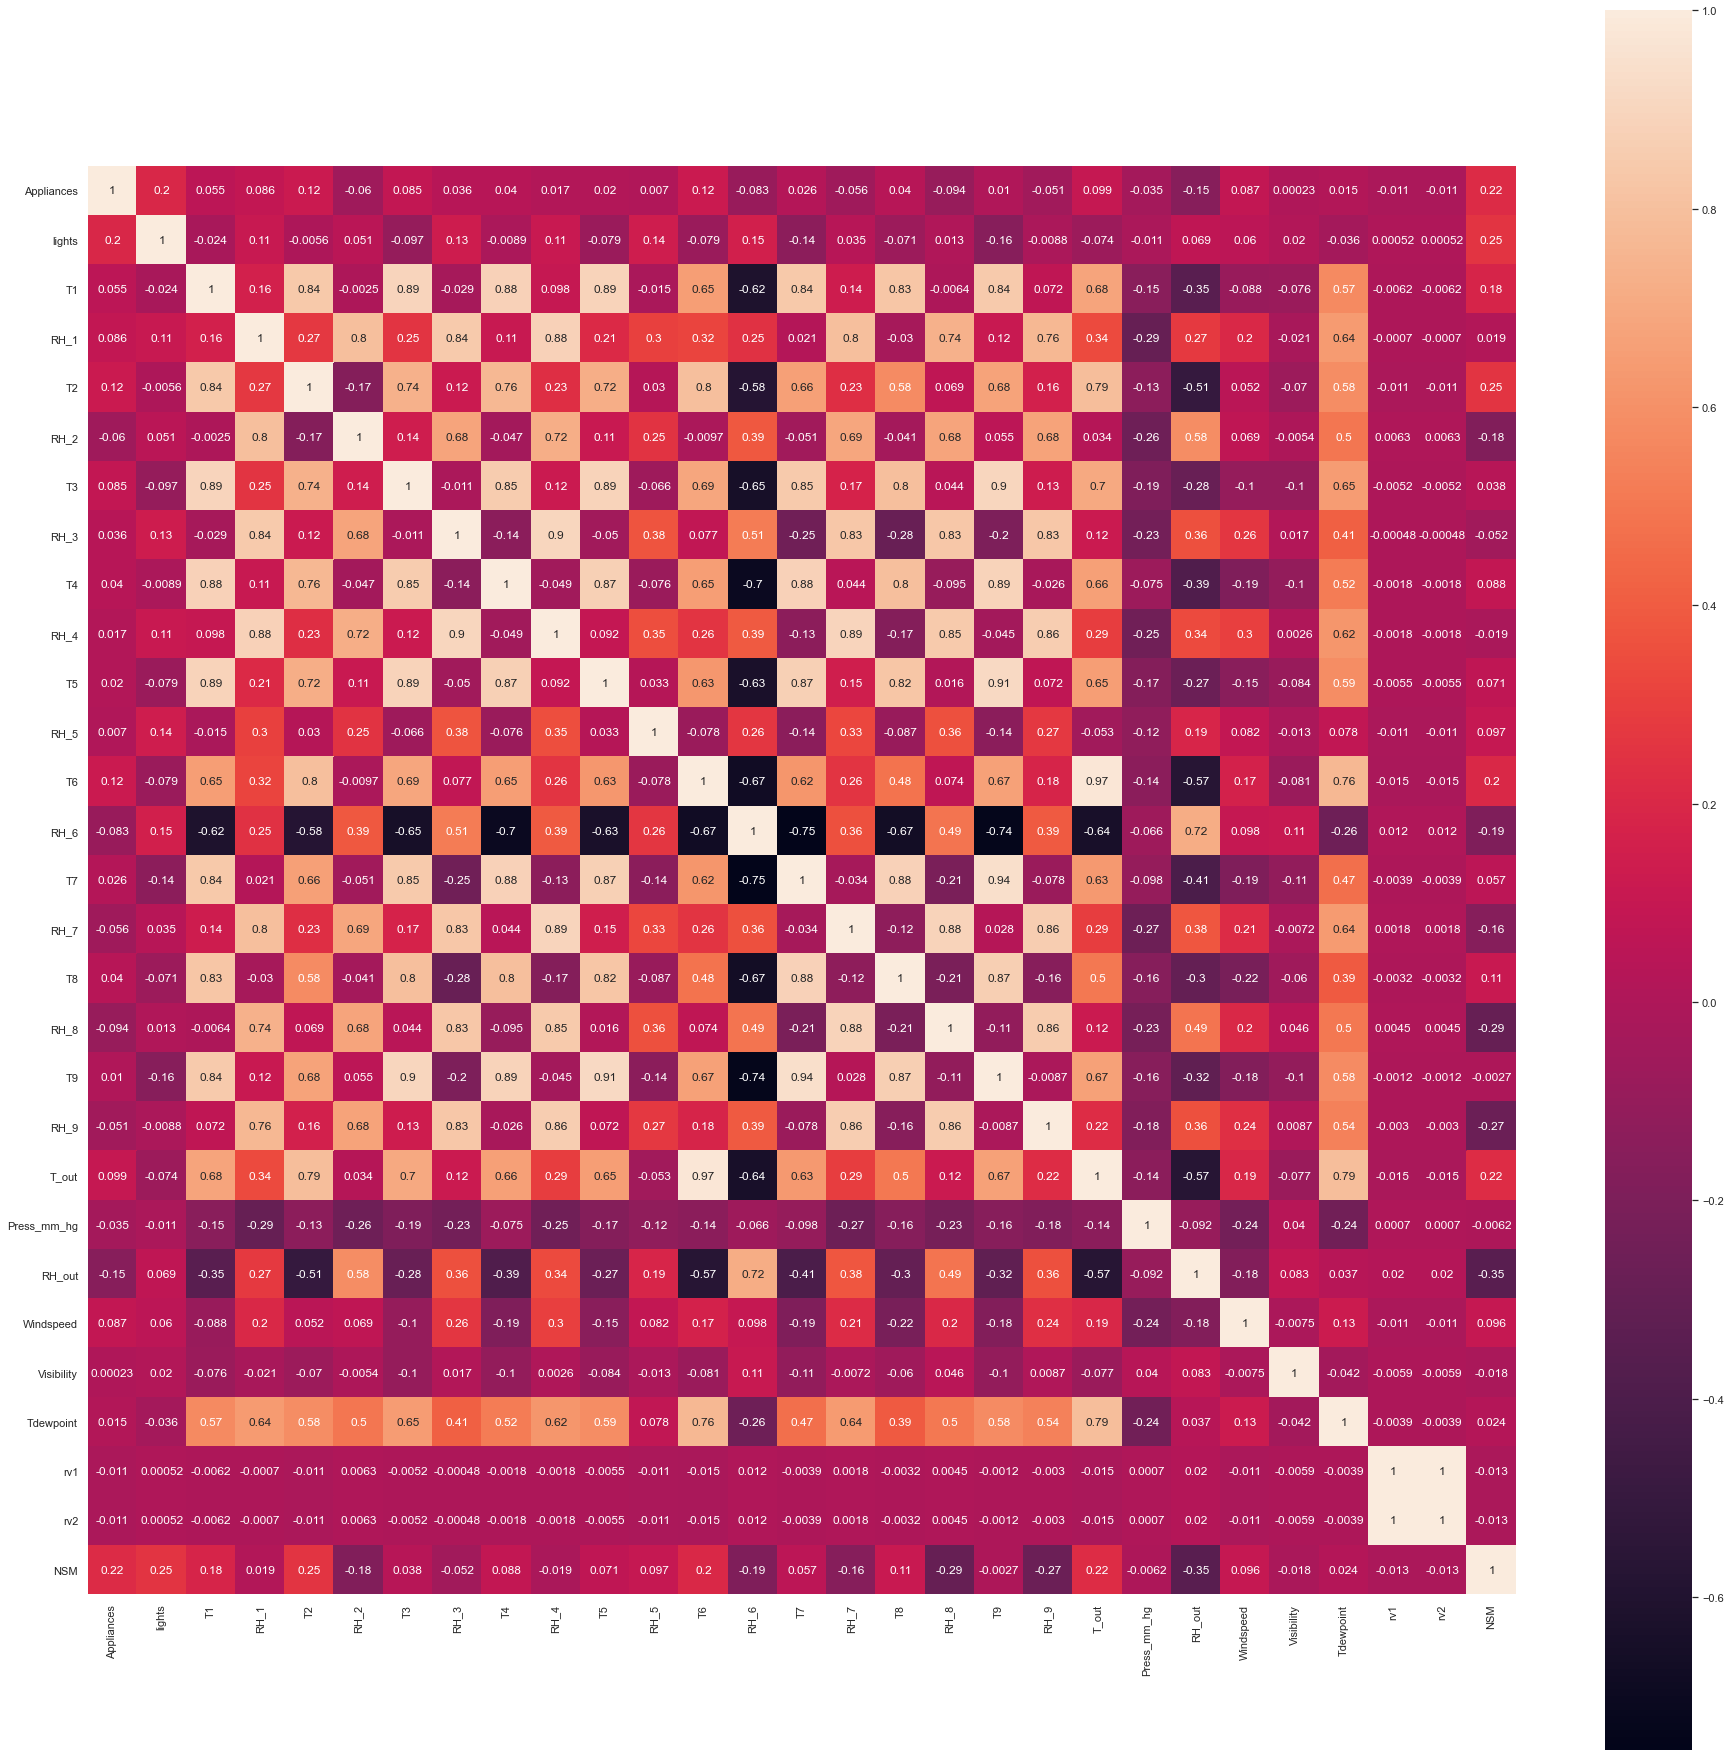

In [32]:
fig = plt.figure(figsize = (32, 32))

sns.heatmap(dtProcessado[quantitativas].corr(method = 'pearson'), annot = True, square = True)
plt.show()

Apartir do Sweetviz confirmamos que possuimos muitas variaveis com alta correlação, o que irá gerar Multicolinearidade, para tentarmos amenizar o impacto iremos utilizar de autovetores. 

Observação: O report foi analisado e anotado insights, porém para melhor compreensão passo a passo dos dados, iremos realizar a analise de forma manual ao longo do notebook.

In [33]:
# Gerando relatorio de analise do Sweetviz
#relatorio = sv.analyze(dtProcessado)
#relatorio.show_html('docs/eda_report.html')

In [34]:
# Remoção de variaveis desnecessárias a primeira vista

dtProcessado = dtProcessado.drop(['rv1', 'rv2'], axis = 1)
quantitativas = quantitativas.drop(['rv1', 'rv2'])

# 4.4 Avaliando MultiColinearidade

In [35]:
dtProcessado_Temp = dtProcessado.copy()
dtProcessado_Temp = dtProcessado_Temp.drop(['date', 'Appliances'], axis = 1)

# Capturando variaveis independentes e dependentes
X = dtProcessado_Temp[quantitativas.drop('Appliances')]

# Gerando matriz de correlação e recombinando
corr = np.corrcoef(X, rowvar = 0)
eigenvalues, eigenvectors = np.linalg.eig(corr)

In [36]:
menor = 999
index = 0
for i, val in enumerate(eigenvalues):
    if val < menor:
        menor = val
        index = i

In [37]:
print('Menor valor do eigenvalues:', menor, 'Index:', index)

Menor valor do eigenvalues: 0.0036995337351865758 Index: 20


In [38]:
menorEigenVector = abs(eigenvectors[:, 19])

In [39]:
for i, val in enumerate(eigenvectors[:, 19]):
    print('Variavel', i,':', abs(val))

Variavel 0 : 0.012508869857297154
Variavel 1 : 0.05999614308799351
Variavel 2 : 0.39796806946142554
Variavel 3 : 0.1293417764198327
Variavel 4 : 0.0065720474555933375
Variavel 5 : 0.20872335203896905
Variavel 6 : 0.7093152784227946
Variavel 7 : 0.07116744022615061
Variavel 8 : 0.002340580766378429
Variavel 9 : 0.10252370243755643
Variavel 10 : 0.009037451481592679
Variavel 11 : 0.016828188950170738
Variavel 12 : 0.3890808789742833
Variavel 13 : 0.052917602709535834
Variavel 14 : 0.09321477213498679
Variavel 15 : 0.01695868232166083
Variavel 16 : 0.18437456347816766
Variavel 17 : 0.048838853198184366
Variavel 18 : 0.017253674475974264
Variavel 19 : 0.004418863747774177
Variavel 20 : 0.03142486038181419
Variavel 21 : 0.18374437578705016
Variavel 22 : 0.010690483150461665
Variavel 23 : 0.0014915408631150135
Variavel 24 : 0.15236584339230871
Variavel 25 : 0.022681722214888112


In [40]:
colunas = dtProcessado_Temp.columns

Analisando as variaveis de indice 11, 19, 21 e 24, aparentam possuir multicolinearidade devido ao seu alto valor absoluto. Porém a sua correlação é baixa, dessa forma iremos aprofundar mais a analise para tomarmos alguma decisão.

In [41]:
colunas[[11, 19, 21, 24]]

Index(['T6', 'T_out', 'RH_out', 'Tdewpoint'], dtype='object')

A variavel 'RH_5' não apresenta um comportamento nitido de correlação com as demais variaveis no scatter_plot. Porém, apresenta uma tendencia pequena de aumento nos valores de 'RH_5' apartir de uma determinada crescente nas variaveis independentes.

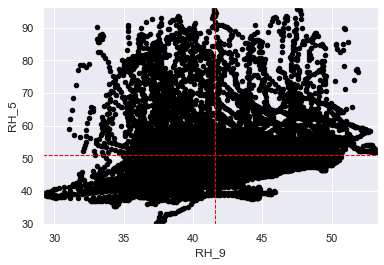

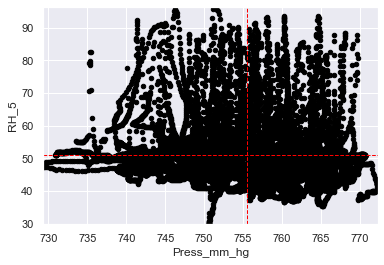

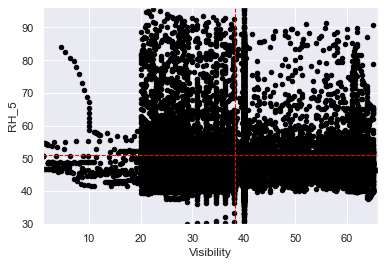

In [42]:
scatter_plot_conjunto(dtProcessado_Temp, ['RH_5', 'RH_9', 'Press_mm_hg', 'Visibility'], 'RH_5')

Para 'RH_9' temos o mesmo detalhe, não apresenta um comportamento nitido de correlação com as demais variaveis no scatter_plot. Porém, apresenta uma tendencia pequena de aumento nos valores de 'RH_9' apartir de uma determinada crescente nas variaveis independentes. 

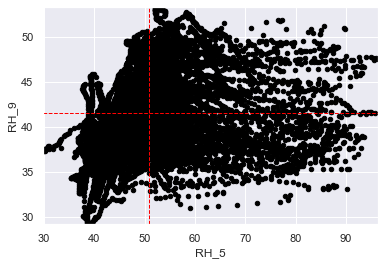

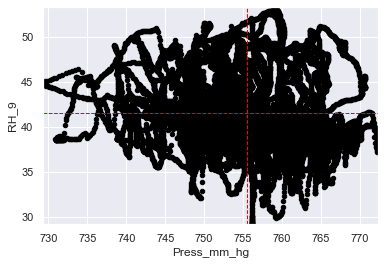

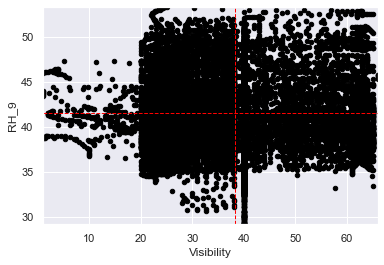

In [43]:
scatter_plot_conjunto(dtProcessado_Temp, ['RH_5', 'RH_9', 'Press_mm_hg', 'Visibility'], 'RH_9')

Para 'RH_9' temos o mesmo detalhe, não apresenta um comportamento nitido de correlação com as demais variaveis no scatter_plot.

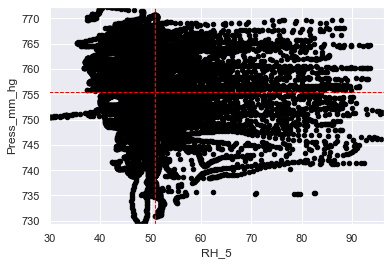

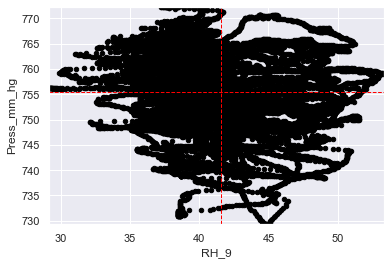

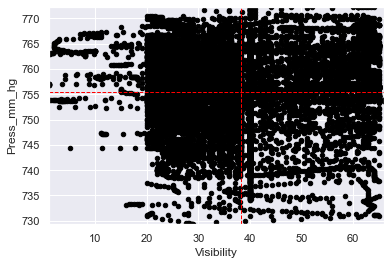

In [44]:
scatter_plot_conjunto(dtProcessado_Temp, ['RH_5', 'RH_9', 'Press_mm_hg', 'Visibility'], 'Press_mm_hg')

Para 'Visibility' temos o mesmo detalhe, não apresenta um comportamento nitido de correlação com as demais variaveis no scatter_plot. Porém, apresenta uma tendencia pequena de aumento nos valores de 'Visibility' apartir de uma determinada crescente nas variaveis independentes.

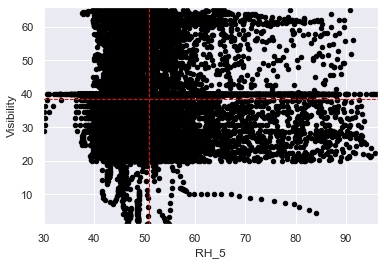

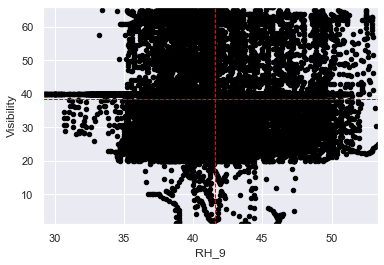

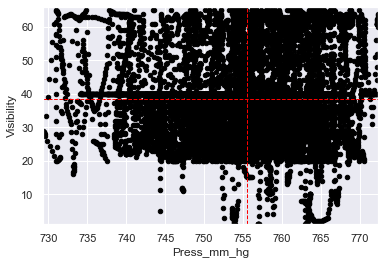

In [45]:
scatter_plot_conjunto(dtProcessado_Temp, ['RH_5', 'RH_9', 'Press_mm_hg', 'Visibility'], 'Visibility')

Analisando as variaveis que apontam possuir alguma Multicolinearidade, até o momento não conseguimos identificar com alta confiança se isso se é verdade. Iremos utilizar VIF para verificar o impacto das variaveis de maneira mais automatizada e acertiva. 

É esperado que valores de VIF = 1 ou proximos a 1 não possua correlação com outras variaveis independentes. Caso VIF ultrapasse valores como 5 ou até 10, possuimos fortes indicios de multicolinearidade entre as variaveis com tal valor.

In [46]:
def calcular_VIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

In [47]:
dtProcessado_Temp = dtProcessado.copy()
dtProcessado_Temp = dtProcessado_Temp.drop(['Appliances'], axis = 1)

# Capturando variaveis independentes
X = dtProcessado_Temp[quantitativas.drop('Appliances')]

Analisando abaixo é perceptivel que a unica variavel com valor baixo para VIF é 'lights'. Assim iremos necessitar de um grande tratamento sobre as variaveis.

In [48]:
calcular_VIF(X)

Features          VIF
0        lights     1.598469
1            T1  3664.675604
2          RH_1  1675.029726
3            T2  2506.573416
4          RH_2  2171.779385
5            T3  1245.642279
6          RH_3  1569.504538
7            T4  1029.698072
8          RH_4  1413.473620
9            T5  1188.789675
10         RH_5    45.918059
11           T6    89.683180
12         RH_6    40.393545
13           T7  1614.407298
14         RH_7   519.500020
15           T8   998.895521
16         RH_8   639.327424
17           T9  2680.167167
18         RH_9   683.068683
19        T_out   399.842239
20  Press_mm_hg  2141.265529
21       RH_out  1304.357699
22    Windspeed     5.265026
23   Visibility    12.033046
24    Tdewpoint   133.401568
25          NSM     8.269484

Abaixo realizamos a primeira tentativa removendo variaveis com VIF > 2000. Porém ainda possuimos alto indice de MultiColinearidade. Iremos remover variaveis com VIF > 1000.

In [49]:
X_temp = X.drop(['T1', 'T2', 'T9', 'Press_mm_hg'], axis = 1)
calcular_VIF(X_temp)

Features          VIF
0       lights     1.535229
1         RH_1  1069.740361
2         RH_2   598.778204
3           T3   931.937502
4         RH_3  1490.346576
5           T4   789.808421
6         RH_4  1229.064681
7           T5   974.129890
8         RH_5    45.234874
9           T6    77.496936
10        RH_6    37.272565
11          T7  1164.586860
12        RH_7   485.753884
13          T8   855.024234
14        RH_8   629.617636
15        RH_9   676.128304
16       T_out   219.666115
17      RH_out   497.869417
18   Windspeed     5.072104
19  Visibility    11.966896
20   Tdewpoint    39.010393
21         NSM     7.406162

Ainda com a remoção de VIF > 1000 estamos com fortes indicios de MultiColinearidade, iremos aumentar o nosso range para VIF > 250.

In [50]:
X_temp = X.drop(['T1', 'T2', 'T9', 'Press_mm_hg', 'RH_1', 'RH_3', 'RH_4', 'T7'], axis = 1)
calcular_VIF(X_temp)

Features         VIF
0       lights    1.474037
1         RH_2  306.256402
2           T3  914.791631
3           T4  647.955577
4           T5  889.230921
5         RH_5   44.725359
6           T6   67.201155
7         RH_6   33.332515
8         RH_7  391.146600
9           T8  590.154997
10        RH_8  490.277232
11        RH_9  545.305393
12       T_out  200.633878
13      RH_out  464.902227
14   Windspeed    4.980792
15  Visibility   11.944881
16   Tdewpoint   31.836147
17         NSM    5.924309

Após uma remoção massiva de variaveis continuamos com alta taxa de MultiColinearidade, iremos remover mais algumas variaveis. Porém, é esperado que iremos fazer mais testews nas variaveis para verificar seu valor para a predição.

In [51]:
X_temp = X.drop(['T1', 'T2', 'T9', 'Press_mm_hg', 'RH_1', 'RH_3', 'RH_4', 'T7', 'T3', 'T4', 'T5', 'T8', 'RH_9', 'RH_2',\
                'RH_7', 'RH_8'], axis = 1)
calcular_VIF(X_temp)

Features        VIF
0      lights   1.386041
1        RH_5  36.610124
2          T6  59.583160
3        RH_6  13.399596
4       T_out  76.338804
5      RH_out  43.804281
6   Windspeed   4.543545
7  Visibility  11.775606
8   Tdewpoint   7.900114
9         NSM   4.957419

Após removermos 21 variaveis das 25 variaveis quantitativas, conseguimos reduzir o VIF para um valor aceitavel, porém é necessário verificar o impacto dessa remoção e se a tecnica para sua remoção foi utilizada da maneira correta.

In [52]:
X_temp = X.drop(['T1', 'T2', 'T9', 'Press_mm_hg', 'RH_1', 'RH_3', 'RH_4', 'T7', 'T3', 'T4', 'T5', 'T8', 'RH_9', 'RH_2',\
                'RH_7', 'RH_8', 'RH_5', 'T_out', 'Visibility', 'RH_out', 'T6'], axis = 1)
calcular_VIF(X_temp)

Features       VIF
0     lights  1.354529
1       RH_6  2.725191
2  Windspeed  3.558092
3  Tdewpoint  1.714626
4        NSM  2.965764

Iremos verificar o valor das variaveis utilizando tanto o dataset original quanto com as variaveis removidas apartir do calculo de VIF. Para isso iremos utilizar um modelo base de regressão lienar do StatsModels.

In [53]:
# Carregando todas variaveis com exceção da 'Target', iremos adicionar a constante exigida pelo modelo
X = dtProcessado_Temp.copy().drop('date', axis = 1)[quantitativas.drop('Appliances')]
Xc = sm.add_constant(X)

y = dtProcessado['Appliances'].values

In [54]:
# Criando e treinando modelo
modelo = sm.OLS(y, Xc)
modelo_v1 = modelo.fit()

Analisando abaixo percemos que o nosso modelo representa somente 16.5% da variancia dos dados, R-squared. Também verificamos que o valor F esta muito alto, sendo inviavel utilizar pare predição. Nosso AIC e BIC já indicam um valor muito alto, o que esta nos sinalizando MultiColinearidade.

Também possuimos variaveis como 'T1', 'RH_4', 'T5', 'RH_5', 'T7' e 'Press_mm_hg' com valores de p > 0.05, indicando que não possui relação com a predição de variaveis. 

Possuimos um 'Omnibus' muito alto, visto que o ideal seria 0. Já Skew e Kurtosis possuem valores relativamente normais para dos que não foram tratados. Já o Durbin-Watson está com um valor relativamente proximo do normal (entre 1 e 2), porém esta indicando que os nossos dados podem estar concentrados, a medida que o ponto de dados aumenta o erro relativo aumenta. Por ultimo, estamos com um 'Conditiom Number' extremamente alto, indicando mais ainda a nossa multicolienaridade.

In [55]:
# Visualizando resumo do modelo
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     152.3
Date:                Sat, 31 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:52:27   Log-Likelihood:            -1.1757e+05
No. Observations:               19735   AIC:                         2.352e+05
Df Residuals:                   19708   BIC:                         2.354e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.2144     94.756     -0.087      0.931    -193.945     177.516
lights          1.9099      0.096     19.944      0.000       1.722       2.098
T1             -2.4021      1.855     -1.295      0.195      -6.039       1.235
RH_1           14.4922      0.675     21.482      0.000      13.170      15.815
T2            -18.0111      1.632    -11.040      0.000     -21.209     -14.813
RH_2          -13.3635      0.766    -17.438      0.000     -14.866     -11.861
T3             26.0199      1.054     24.697      0.000      23.955      28.085
RH_3            4.8021      0.674      7.127      0.000       3.481       6.123
T4             -3.1388      1.024     -3.066      0.002      -5.146      -1.132
RH_4           -0.7810      0.640     -1.220      0.223      -2.036       0.474
T5             -0.3787      1.172     -0.323      0.747      -2.677       1.919
RH_5            0.0617      0.087      0.707      0.480      -0.109       0.233
T6              7.5680      0.636     11.906      0.000       6.322       8.814
RH_6            0.2863      0.068      4.232      0.000       0.154       0.419
T7              1.8028      1.321      1.364      0.172      -0.787       4.393
RH_7           -1.4776      0.429     -3.445      0.001      -2.318      -0.637
T8              7.4096      0.972      7.626      0.000       5.505       9.314
RH_8           -3.7938      0.390     -9.739      0.000      -4.557      -3.030
T9            -13.2966      1.792     -7.422      0.000     -16.808      -9.785
RH_9           -0.1390      0.421     -0.330      0.741      -0.964       0.686
T_out         -10.1001      1.519     -6.650      0.000     -13.077      -7.123
Press_mm_hg     0.1501      0.107      1.405      0.160      -0.059       0.359
RH_out         -0.8495      0.315     -2.696      0.007      -1.467      -0.232
Windspeed       1.7940      0.345      5.200      0.000       1.118       2.470
Visibility      0.1525      0.058      2.645      0.008       0.039       0.266
Tdewpoint       3.8372      1.483      2.587      0.010       0.930       6.744
NSM             0.0003   3.87e-05      7.614      0.000       0.000       0.000
==============================================================================
Omnibus:                    13963.593   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           211283.363
Skew:                           3.321   Prob(JB):                         0.00
Kurtosis:                      17.588   Cond. No.                     7.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+06. This might indicate that there are
strong multicollinearity or o

Abaixo iremos criar o modelo novamente porém a redução de variaveis implicadas pelo p value e VIF.

In [56]:
# Carregando variaveis com exceção
Xc = sm.add_constant(X_temp)

y = dtProcessado['Appliances'].values

In [57]:
# Criando e treinando modelo
modelo = sm.OLS(y, Xc)
modelo_v2 = modelo.fit()

Treinando o modelo com a remoção de variaveis, notamos que tivemos uma grande redução no R-Squared, trazendo uma significancia de apenas 6% da variancia dos nossos dados. Devemos tentar escolher variaveis melhores para o nosso modelo, consequentemente levou ao aumento do valor F e diminuição do 'Log-Likelihood'.

Outros valores permaneceram com resultados semelhantes, com exceção de 'Conditiom Number' que reduziu drasticamente ao ponto de não sofrermos mais multicolinearidade.

Iremos ter que avaliar melhor quais variaveis utilizar para o nosso modelo, afim de reduzir a MultiColinearidade sem perder variaveis de valor.

In [58]:
# Visualizando resumo do modelo
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     341.1
Date:                Sat, 31 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:52:28   Log-Likelihood:            -1.1856e+05
No. Observations:               19735   AIC:                         2.371e+05
Df Residuals:                   19729   BIC:                         2.372e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.4136      2.408     28.414      0.000      63.694      73.133
lights         2.1715      0.093     23.246      0.000       1.988       2.355
RH_6          -0.3018      0.025    -12.299      0.000      -0.350      -0.254
Windspeed      3.0766      0.293     10.502      0.000       2.502       3.651
Tdewpoint     -0.3754      0.175     -2.142      0.032      -0.719      -0.032
NSM            0.0006   3.01e-05     20.496      0.000       0.001       0.001
==============================================================================
Omnibus:                    14148.097   Durbin-Watson:                   0.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           206087.033
Skew:                           3.405   Prob(JB):                         0.00
Kurtosis:                      17.292   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4.5 Simetria dos Dados

### 4.5.1 Skewness

Esperamos valores de Skewness proximo de 0 para uma simetria perfeita.

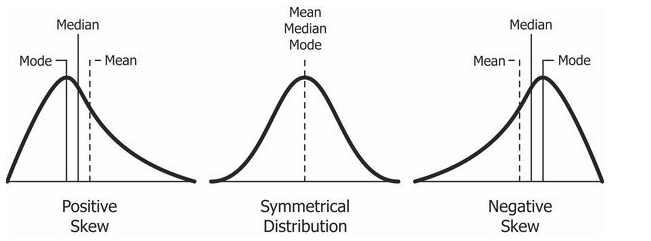

- Se skewness é menor que −1 ou maior que +1, a distribuição é 'highly skewed'.

- Se skewness esta entre −1 e −½ ou entre +½ e +1, a distribuição é 'moderately skewed'.

- Se skewness esta entre −½ e +½, a distribuição é aproximadaente simetrica.

Olhando primeiramente para o Skewness, possuimos variaveis com alta simetria o que é muito bom para os algoritmos de Machine Learnign em geral. Porém possuimo a variavel 'lights' com um simetria muito acima de 0. Já as outras variaveis possuem um Skewness aceitavel, valores maiores que 0.5 ou menores que -0.5 indicam que a simetria já começa a se perder, porém ainda é aceitavel.

In [59]:
print(dtProcessado[quantitativas].skew(), '\nSoma:', sum(abs(dtProcessado[quantitativas].skew())))

Appliances     3.386367
lights         2.195155
T1             0.120917
RH_1           0.465774
T2             0.889658
RH_2          -0.268247
T3             0.450777
RH_3           0.467589
T4             0.170384
RH_4           0.444614
T5             0.558220
RH_5           1.866820
T6             0.597471
RH_6          -0.241961
T7             0.254722
RH_7           0.242141
T8            -0.256151
RH_8           0.308036
T9             0.382711
RH_9           0.368937
T_out          0.534273
Press_mm_hg   -0.420442
RH_out        -0.922997
Windspeed      0.859982
Visibility     0.441554
Tdewpoint      0.239374
NSM           -0.000670
dtype: float64 
Soma: 17.355945524815315


### 4.5.2 Histograma

In [60]:
def hist_individual(data, columns, width = 10, height = 15):
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    columns_adjust = ceil(len(columns) / 3)
    
    for i, column in enumerate(columns):
        ax = fig.add_subplot(columns_adjust, 3, i + 1)
        data[column].hist(label = column)
        plt.title(column)
        
    plt.tight_layout()  
    plt.show()

Abaixo iremos verificar o histograma das variaveis. Porém para visualizarmos de uma melhor forma iremos separar em grupos de plots abaixo. Fica perceptivel que 'Appliances' e'lights' não possuem simetria, devido a sua alta concentração entre 0 e 10. Porém variaveis como 'T1' e 'T4' possuem alta simetria.

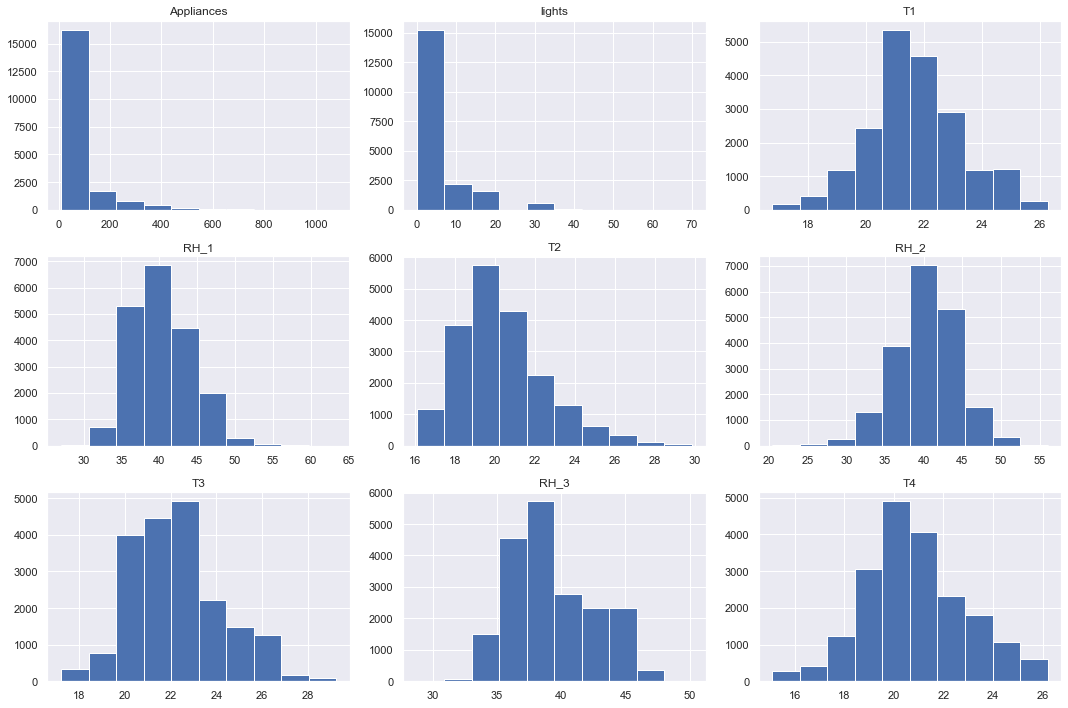

In [61]:
hist_individual(dtProcessado, quantitativas[0:9])

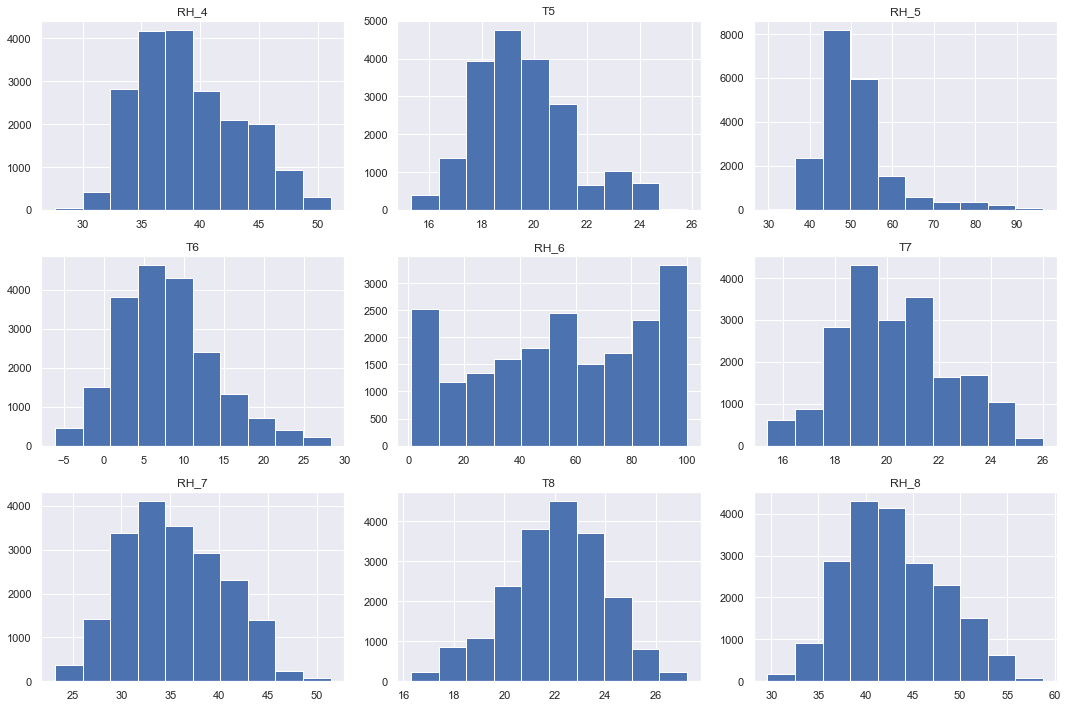

In [62]:
hist_individual(dtProcessado, quantitativas[9:18])

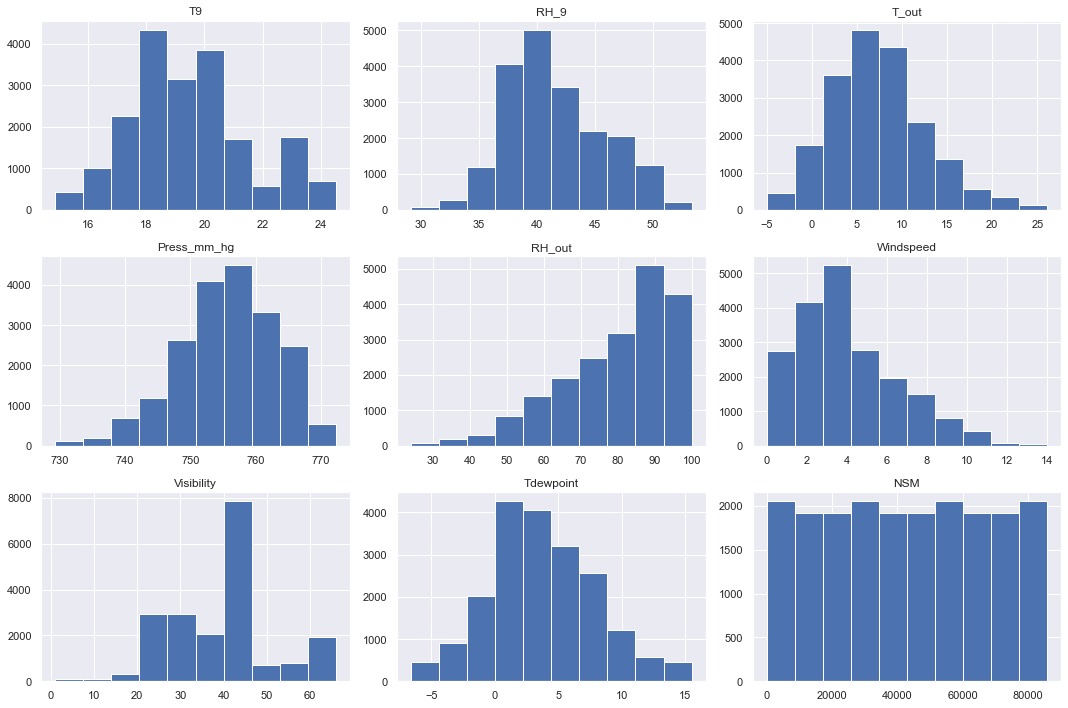

In [63]:
hist_individual(dtProcessado, quantitativas[18:27])

### 4.5.3 Exceço de Kurtosis

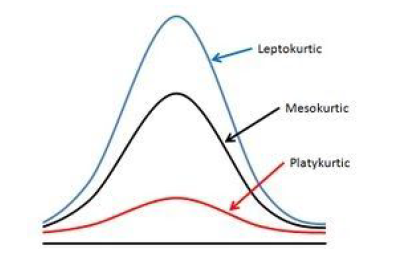

Mesokurtic -> Kurtosis ~= 0: Distribuição normal.

Leptokurtic -> Kurtosis > 0: Valores proximos a media ou dos extremos.

Platykurtic -> Kurtosis < 0: Valores muito espalhados.

É perceptivel que variaveis como 'Appliances', 'lights' e 'RH_5' claramente estão distantes de uma distribuição normal, porém outras variaveis se aproximam de uma distribuição Gaussiana, com valores maiores que 3 e menores que 4. Também é perceptivel qque possuimos muitas variaveis com o comportamento de uma 'Platykurtic', ou seja valores muito espalhados. 

In [64]:
print(dtProcessado[quantitativas].kurtosis(), '\nSoma:', sum(abs(dtProcessado[quantitativas].kurtosis())))

Appliances     13.667863
lights          4.462147
T1              0.161601
RH_1            0.112629
T2              0.933397
RH_2            0.670959
T3             -0.007055
RH_3           -0.583126
T4             -0.037633
RH_4           -0.613967
T5              0.112724
RH_5            4.503391
T6              0.425549
RH_6           -1.142064
T7             -0.461165
RH_7           -0.544889
T8             -0.158742
RH_8           -0.481962
T9             -0.324625
RH_9           -0.405540
T_out           0.364291
Press_mm_hg     0.071831
RH_out          0.256859
Windspeed       0.250030
Visibility      0.165818
Tdewpoint      -0.124519
NSM            -1.200156
dtype: float64 
Soma: 32.24453232465741


## 4.6 Analise Temporal

### 4.6.1 Pre-Processamento colunas temporais

Para realizarmos uma analise eficiente das variaveis temporais, iremos transforma-las, adicionando coluna de 'Month', 'Day', 'Hour', e convertendo coluna 'Day_of_week' e 'WeekStatus' para numericas.

In [65]:
# Renomeando coluna WeekStatus para Weekend
dtProcessado = dtProcessado.rename(columns = {'WeekStatus': 'Weekend'})

In [66]:
# Dia de semana = 0, final de semana = 1
dtProcessado['Day_of_week'] = dtProcessado['date'].dt.dayofweek
dtProcessado['Weekend'] = 0

dtProcessado.loc[(dtProcessado['Day_of_week'] == 5) | (dtProcessado['Day_of_week'] == 6), 'Weekend'] = 1

In [67]:
# Criando colunan de Mês, Dia e Hora
dtProcessado['Month'] = dtProcessado['date'].dt.month
dtProcessado['Day'] = dtProcessado['date'].dt.day
dtProcessado['Hour'] = dtProcessado['date'].dt.hour

In [68]:
dtProcessado.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2 2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3 2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4 2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  RH_out  Windspeed  Visibility  Tdewpoint  \
0  19.79  44.730000  19.000000  ...    92.0   7.000000   63.000000        5.3   
1  19.79  44.790000  19.000000  ...    92.0   6.666667   59.166667        5.2   
2  19.79  44.933333  18.926667  ...    92.0   6.333333   55.333333        5.1   
3  19.79  45.000000  18.890000  ...    92.0   5.666667   47.666667        4.9   
4  19.79  44.933333  18.890000  ...    92.0   5.333333   43.833333        4.8   

     NSM  Weekend  Day_of_week  Month  Day  Hour  
0  61200        0            0      1   11    17  
1  61800        0            0      1   11    17  
2  62400        0            0      1   11    17  
3  63600        0            0      1   11    17  
4  64200        0            0      1   11    17  

[5 rows x 33 columns]

### 4.6.2 Analise Temporal de Gasto Energia

Abaixo percebemos que o gasto energetico por dia da semana tende a iniciar alto na Segunda / 0 em 115 Wh, passando por um queda para 80-85 Wh até Quinta, voltando a subir até os 105 Wh na Sexta e Sabado. Por ultimo, voltamos a uma queda por volta dos 85 Wh no Domingo.

Apartir desse cenario, podemos visualizar que a Segunda passa a ser um dia onde as pessoas gastam maior energia, talvez por estar começando a semana com maior foco em atividades que leval a gasto de energia eletrica. Com uma queda ao longo da semana, que volta a subir proximo ao final de semana, onde temos dias de descanso que passam a acontecer em casa, e por ultimo no domingo onde tende a ser dias para saida de familia.

Claro que o cenario acima é somente uma hipotese, porém representar a realidade de algumas pessoas, para um melhor entendimento poderia ser feito uma pesquisa do estilo de vida do cidadões de onde foi retirado o dataset.

[]

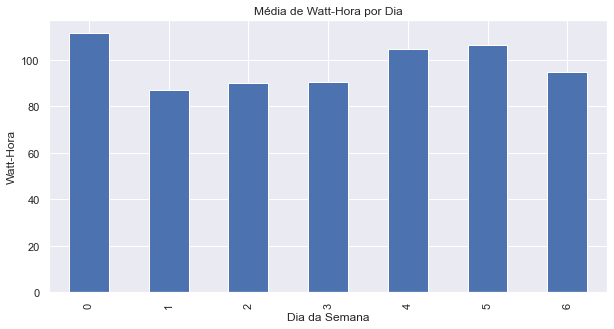

In [69]:
fig, ax = plt.subplots(figsize = (10, 5))
dtProcessado.groupby('Day_of_week').mean()['Appliances'].plot(kind = 'bar')

ax.set_title('Média de Watt-Hora por Dia')
ax.set_ylabel('Watt-Hora')
ax.set_xlabel('Dia da Semana')
plt.plot()

[]

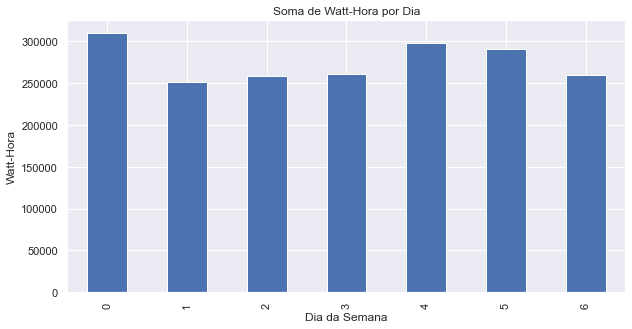

In [70]:
fig, ax = plt.subplots(figsize = (10, 5))
dtProcessado.groupby('Day_of_week').sum()['Appliances'].plot(kind = 'bar')

ax.set_title('Soma de Watt-Hora por Dia')
ax.set_ylabel('Watt-Hora')
ax.set_xlabel('Dia da Semana')
plt.plot()

É analisado que o gasto de hora começa a subir aproximadamente as 6 da manhã até as 11 horas da manhã chegar em um pico de 130 Wh, depois temos uma queda até os 100 Wh e voltamos a subir pro volta das 15 horas da tarde, até chegar ao pico de 180 Wh as 18 horas, apartir desse momento vamos caindo o nivel de energia até chegar abaixo dos 60 Wh as 23 horas.

[]

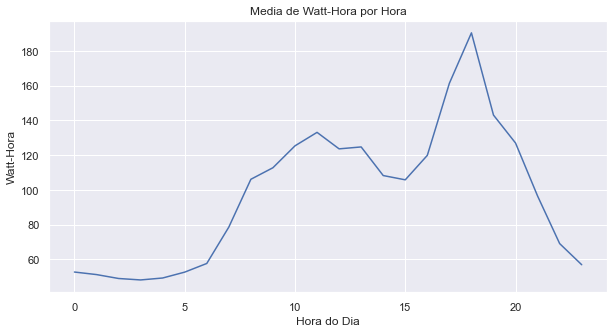

In [71]:
fig, ax = plt.subplots(figsize = (10, 5))
dtProcessado.groupby('Hour').mean()['Appliances'].plot(kind = 'line')

ax.set_title('Media de Watt-Hora por Hora')
ax.set_ylabel('Watt-Hora')
ax.set_xlabel('Hora do Dia')
plt.plot()

[]

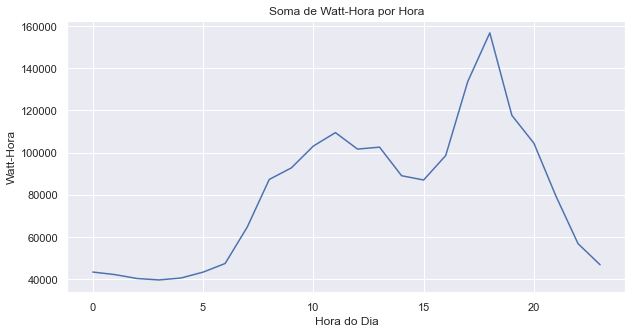

In [72]:
fig, ax = plt.subplots(figsize = (10, 5))
dtProcessado.groupby('Hour').sum()['Appliances'].plot(kind = 'line')

ax.set_title('Soma de Watt-Hora por Hora')
ax.set_ylabel('Watt-Hora')
ax.set_xlabel('Hora do Dia')
plt.plot()

In [73]:
# Criando copia do data set
dtProcessado_temporal = dtProcessado.copy()

# Set da data como index
dtProcessado_temporal.index = dtProcessado_temporal['date']
dtProcessado_temporal = dtProcessado_temporal.drop('date', axis = 1)

In [74]:
dtProcessado_temporal.head()

Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

                        T3       RH_3         T4       RH_4  ...  RH_out  \
date                                                         ...           
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...    92.0   
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500  ...    92.0   
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000  ...    92.0   
2016-01-11 17:40:00  19.79  45.000000  18.890000  45.530000  ...    92.0   
2016-01-11 17:50:00  19.79  44.933333  18.890000  45.730000  ...    92.0   

                     Windspeed  Visibility  Tdewpoint    NSM  Weekend  \
date                                                                    
2016-01-11 17:00:00   7.000000   63.000000        5.3  61200        0   
2016-01-11 17:10:00   6.666667   59.166667        5.2  61800        0   
2016-01-11 17:20:00   6.333333   55.333333        5.1  62400        0   
2016-01-11 17:40:00   5.666667   47.666667        4.9  63600        0   
2016-01-11 17:50:00   5.333333   43.833333        4.8  64200        0   

                     Day_of_week  Month  Day  Hour  
date                                                
2016-01-11 17:00:00            0      1   11    17  
2016-01-11 17:10:00            0      1   11    17  
2016-01-11 17:20:00            0      1   11    17  
2016-01-11 17:40:00            0      1   11    17  
2016-01-11 17:50:00            0      1   11    17  

[5 rows x 32 columns]

In [75]:
# Calculando media por data
dtProcessado_Dia = dtProcessado_temporal['Appliances'].resample('D').mean()

# Calculando media até a data atual
media_momentanea = pd.Series(\
                        [np.mean(dtProcessado_Dia[:x]) for x in range(len(dtProcessado_Dia))]\
                        )

media_momentanea.index = dtProcessado_Dia.index

Percebe-se que o gasto de energia vem oscilando bastante entre os meses, porém mantem uma média constante devido ao alto volume de dados. Talvez a coluna 'Mês' e 'Dia' possuam uma representatividade interessante para o modelo.

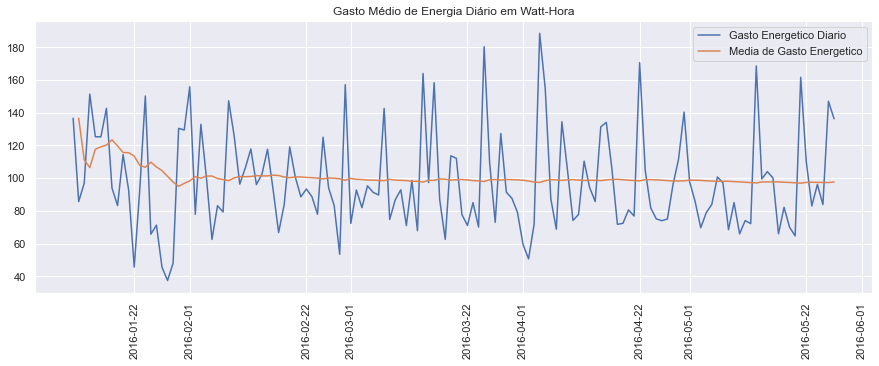

In [76]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(dtProcessado_Dia, label = 'Gasto Energetico Diario')
plt.plot(media_momentanea, label = 'Media de Gasto Energetico')
plt.legend()
plt.xticks(rotation = 90)

ax.set_title('Gasto Médio de Energia Diário em Watt-Hora');

# 5. Pre-Processamento

## 5.1 Removendo Colunas Desnecessárias

Abaixo iremos remover as colunas que mostraram se sem valor durante a analise exploratoria.

In [77]:
dtProcessado = dtProcessado.drop(['date'], axis = 1)

In [78]:
dtProcessado.head()

Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   
3          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000   
4          50      40  19.89  46.026667  19.2  44.500000  19.79  44.933333   

          T4       RH_4  ...  RH_out  Windspeed  Visibility  Tdewpoint    NSM  \
0  19.000000  45.566667  ...    92.0   7.000000   63.000000        5.3  61200   
1  19.000000  45.992500  ...    92.0   6.666667   59.166667        5.2  61800   
2  18.926667  45.890000  ...    92.0   6.333333   55.333333        5.1  62400   
3  18.890000  45.530000  ...    92.0   5.666667   47.666667        4.9  63600   
4  18.890000  45.730000  ...    92.0   5.333333   43.833333        4.8  64200   

   Weekend  Day_of_week  Month  Day  Hour  
0        0            0      1   11    17  
1        0            0      1   11    17  
2        0            0      1   11    17  
3        0            0      1   11    17  
4        0            0      1   11    17  

[5 rows x 32 columns]

## 5.2 Detectando Outliers

In [79]:
def boxplot_individuais(data, columns, width = 15, height = 8):
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    
    columns_adjust = ceil(len(columns) / 3)
    
    for i, column in enumerate(columns):
        ax = fig.add_subplot(columns_adjust, 3, i + 1)
        sns.boxplot(x = data[column])
        
    plt.tight_layout()  
    plt.show()

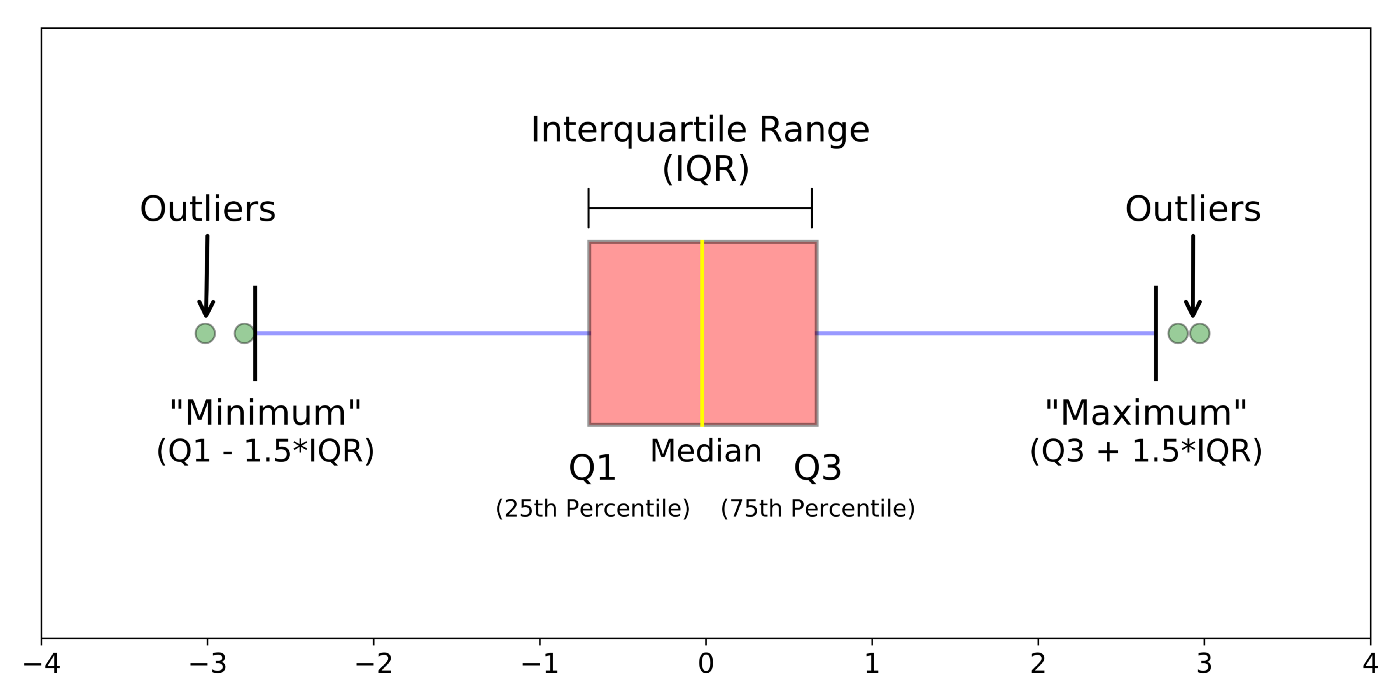

É perceptivel que com exceção das variaveis: 'RH_4', 'RH_6', 'T7' e 'T9', todas as outras variaveis possuem outliers. Alguns possuem somentne acima do limite inferior, outras apenas do limite superior. Ainda poussimos os casos de variaveis que possuem em ambos os limites.

Para tratar os outliers iremos utilizar a tecnnica de IQR, iremos mover os dados abaixo do limite inferior para o limite inferior, já para o limite superior iremos mover os dados acima do mesmo para o limite superior.

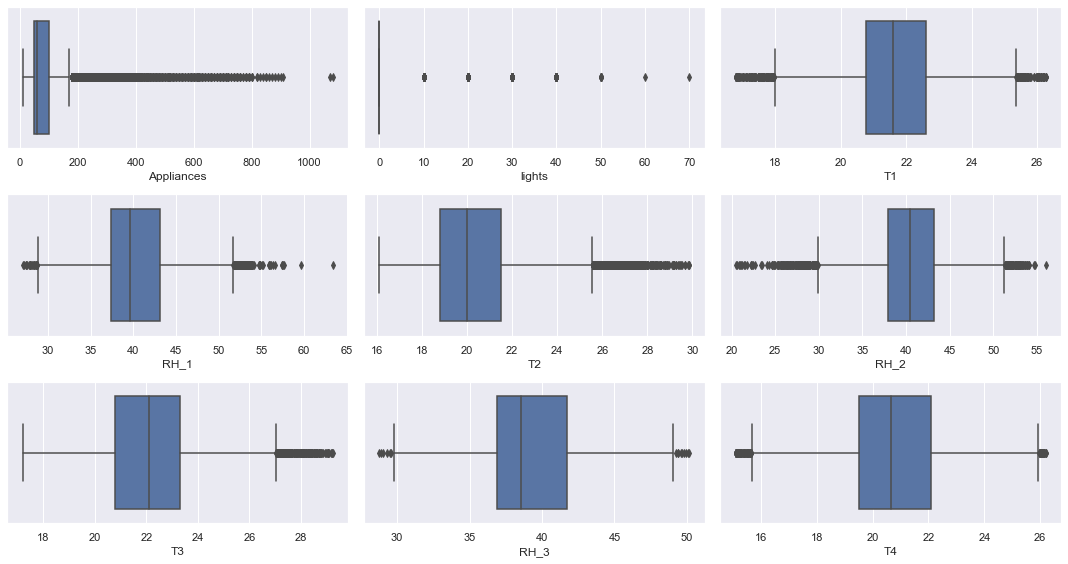

In [80]:
boxplot_individuais(dtProcessado, quantitativas[0:9])

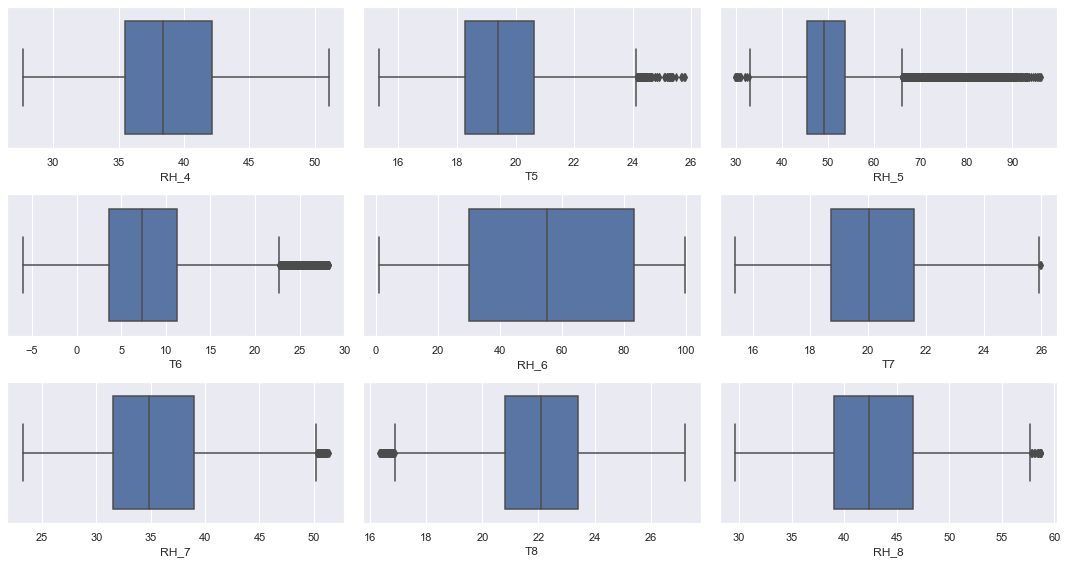

In [81]:
boxplot_individuais(dtProcessado, quantitativas[9:18])

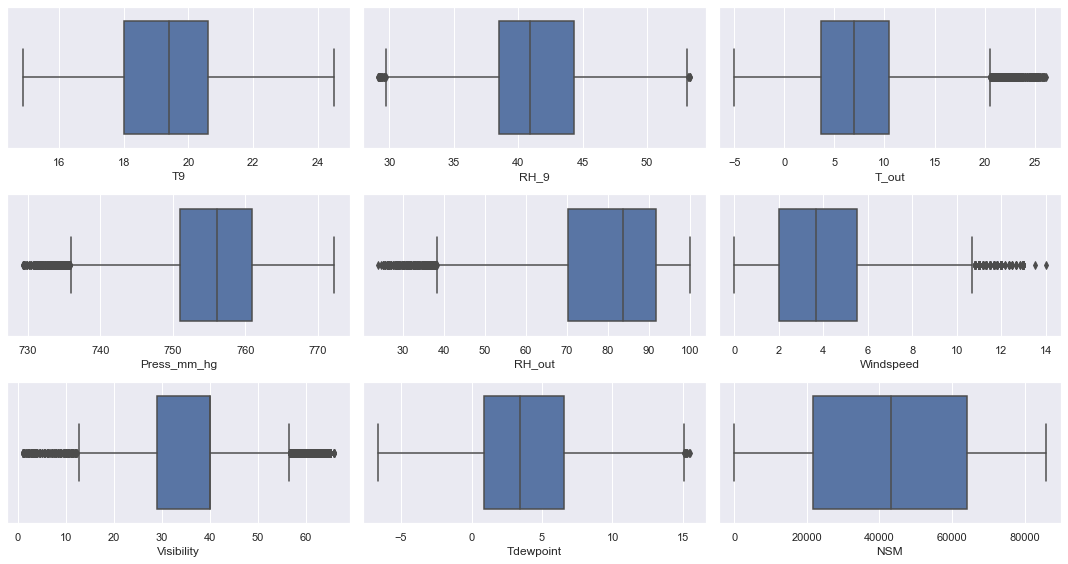

In [82]:
boxplot_individuais(dtProcessado, quantitativas[18:27])

## 5.3 Tratando Outliers

In [83]:
def calcular_limites_IQR(column):
    # Calcular Q1 e Q3 do array
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    return limite_inferior, limite_superior

def aplicar_IQR_coluna(column, superior, inferior):
    limite_inferior, limite_superior = calcular_limites_IQR(column)
    
    if inferior:
        column = [limite_inferior if x < limite_inferior else x for x in column]
        
    if superior:      
        column = [limite_superior if x > limite_superior else x for x in column]
    
    return column

def aplicar_IQR(data, columns = [], superior = True, inferior = True):
    
    if len(columns) == 0:
        especificar = False
    else:
        especificar = True
    
    for i, column in enumerate(data.columns):
        if especificar:
            if column in columns:
                data[column] = aplicar_IQR_coluna(data[column], superior, inferior)
        else:
            data[column] = aplicar_IQR_coluna(data[column], superior, inferior)
            
    return data

Dataset antes da aplicação do IQR para correção de outliers.

In [84]:
dtProcessado.describe()

Appliances        lights            T1          RH_1            T2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875     21.686571     40.259739     20.341219   
std      102.524891      7.935988      1.606066      3.979299      2.192974   
min       10.000000      0.000000     16.790000     27.023333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max     1080.000000     70.000000     26.260000     63.360000     29.856667   

               RH_2            T3          RH_3            T4          RH_4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.420420     22.267611     39.242500     20.855335     39.026904   
std        4.069813      2.006111      3.254576      2.042884      4.341321   
min       20.463333     17.200000     28.766667     15.100000     27.660000   
25%       37.900000     20.790000     36.900000     19.530000     35.530000   
50%       40.500000     22.100000     38.530000     20.666667     38.400000   
75%       43.260000     23.290000     41.760000     22.100000     42.156667   
max       56.026667     29.236000     50.163333     26.200000     51.090000   

       ...        RH_out     Windspeed    Visibility     Tdewpoint  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...     79.750418      4.039752     38.330834      3.760707   
std    ...     14.901088      2.451221     11.794719      4.194648   
min    ...     24.000000      0.000000      1.000000     -6.600000   
25%    ...     70.333333      2.000000     29.000000      0.900000   
50%    ...     83.666667      3.666667     40.000000      3.433333   
75%    ...     91.666667      5.500000     40.000000      6.566667   
max    ...    100.000000     14.000000     66.000000     15.500000   

                NSM       Weekend   Day_of_week         Month           Day  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean   42907.129465      0.277274      2.977249      3.101647     16.057411   
std    24940.020831      0.447664      1.985617      1.339200      8.450998   
min        0.000000      0.000000      0.000000      1.000000      1.000000   
25%    21600.000000      0.000000      1.000000      2.000000      9.000000   
50%    43200.000000      0.000000      3.000000      3.000000     16.000000   
75%    64200.000000      1.000000      5.000000      4.000000     23.000000   
max    85800.000000      1.000000      6.000000      5.000000     31.000000   

               Hour  
count  19735.000000  
mean      11.502002  
std        6.921953  
min        0.000000  
25%        6.000000  
50%       12.000000  
75%       17.000000  
max       23.000000  

[8 rows x 32 columns]

In [85]:
dtProcessado_IQR = dtProcessado.copy()
dtProcessado_IQR = aplicar_IQR(dtProcessado_IQR, columns = dtProcessado_IQR.columns.copy().drop(['lights',\
                                                                    'Weekend', 'Day_of_week', 'Month', 'Day', 'Hour']))

Dataset após aplicação do IQR para correção de outliers. Percebe-se que valores minimos e maximos passaram a ser muito mais realistas, também é perceptivel mudanças na média. Considerando que temos mais de 19 mil registros, uma mudança na média passa a ser muito significativo.

Observação: Não foi aplicado IQR em 'lights' por uma baixa concentração de outliers, também ocorre que ao aplicar IQR em 'lights', todos os valores são zerados.

In [86]:
dtProcessado_IQR.describe()

Appliances        lights            T1          RH_1            T2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      78.887256      3.801875     21.689928     40.249990     20.307042   
std       42.961298      7.935988      1.580210      3.942554      2.093877   
min       10.000000      0.000000     18.000000     28.733333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max      175.000000     70.000000     25.360000     51.666667     25.565000   

               RH_2            T3          RH_3            T4          RH_4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.438762     22.259048     39.242344     20.857620     39.026904   
std        3.982628      1.982974      3.253254      2.035499      4.341321   
min       29.860000     17.200000     29.610000     15.675000     27.660000   
25%       37.900000     20.790000     36.900000     19.530000     35.530000   
50%       40.500000     22.100000     38.530000     20.666667     38.400000   
75%       43.260000     23.290000     41.760000     22.100000     42.156667   
max       51.300000     27.040000     49.050000     25.955000     51.090000   

       ...        RH_out     Windspeed    Visibility     Tdewpoint  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...     79.816249      4.030209     37.745520      3.760621   
std    ...     14.698986      2.421942     10.419724      4.194413   
min    ...     38.333333      0.000000     12.500000     -6.600000   
25%    ...     70.333333      2.000000     29.000000      0.900000   
50%    ...     83.666667      3.666667     40.000000      3.433333   
75%    ...     91.666667      5.500000     40.000000      6.566667   
max    ...    100.000000     10.750000     56.500000     15.066667   

                NSM       Weekend   Day_of_week         Month           Day  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean   42907.129465      0.277274      2.977249      3.101647     16.057411   
std    24940.020831      0.447664      1.985617      1.339200      8.450998   
min        0.000000      0.000000      0.000000      1.000000      1.000000   
25%    21600.000000      0.000000      1.000000      2.000000      9.000000   
50%    43200.000000      0.000000      3.000000      3.000000     16.000000   
75%    64200.000000      1.000000      5.000000      4.000000     23.000000   
max    85800.000000      1.000000      6.000000      5.000000     31.000000   

               Hour  
count  19735.000000  
mean      11.502002  
std        6.921953  
min        0.000000  
25%        6.000000  
50%       12.000000  
75%       17.000000  
max       23.000000  

[8 rows x 32 columns]

## 5.4 Feature Scaling

### 5.4.1 Aplicando Padronização

Para os algoritmos que iremos utilizar como SVM, XGBoost e Regressão Logística Multilinear a padronização se mostra mais relevante. Como nossas variaveis 

In [87]:
# Padronização dos dados
scaler = StandardScaler()
processado_IQR_padronizado = dtProcessado_IQR.copy()
processado_IQR_padronizado[quantitativas.drop('Appliances')] = scaler.fit_transform(\
                                                                    dtProcessado_IQR[quantitativas.drop('Appliances')])

In [88]:
'''
# Padronização dos dados
scaler = StandardScaler()
processado_IQR_padronizado = dtProcessado_IQR.copy()
processado_IQR_padronizado[quantitativas] = scaler.fit_transform(dtProcessado_IQR[quantitativas])
'''

'\n# Padronização dos dados\nscaler = StandardScaler()\nprocessado_IQR_padronizado = dtProcessado_IQR.copy()\nprocessado_IQR_padronizado[quantitativas] = scaler.fit_transform(dtProcessado_IQR[quantitativas])\n'

Após realizar a padronização dos dados, iremos revisitar algumas metricas como skewness, kurtose e boxplot stats.

In [89]:
dtProcessado_IQR_padronizado = pd.DataFrame(processado_IQR_padronizado.copy(), columns = dtProcessado_IQR.columns)

In [90]:
dtProcessado_IQR_padronizado.head()

Appliances    lights        T1      RH_1        T2      RH_2        T3  \
0        60.0  3.301264 -1.139072  1.863478 -0.528718  1.092582 -1.245155   
1        60.0  3.301264 -1.139072  1.634348 -0.528718  1.075633 -1.245155   
2        50.0  3.301264 -1.139072  1.534580 -0.528718  1.051570 -1.245155   
3        60.0  4.561378 -1.139072  1.543034 -0.528718  1.027297 -1.245155   
4        50.0  4.561378 -1.139072  1.465249 -0.528718  1.019764 -1.245155   

       RH_3        T4      RH_4  ...    RH_out  Windspeed  Visibility  \
0  1.686863 -0.912635  1.506438  ...  0.828905   1.226233    1.799947   
1  1.705307 -0.912635  1.604528  ...  0.828905   1.088599    1.799947   
2  1.749367 -0.948663  1.580918  ...  0.828905   0.950965    1.687977   
3  1.769859 -0.966677  1.497991  ...  0.828905   0.675697    0.952175   
4  1.749367 -0.966677  1.544061  ...  0.828905   0.538063    0.584273   

   Tdewpoint       NSM  Weekend  Day_of_week  Month  Day  Hour  
0   0.367016  0.733493        0            0      1   11    17  
1   0.343175  0.757551        0            0      1   11    17  
2   0.319333  0.781610        0            0      1   11    17  
3   0.271649  0.829726        0            0      1   11    17  
4   0.247807  0.853785        0            0      1   11    17  

[5 rows x 32 columns]

### 5.4.2 Analisando Dados Pós Padronização

Verificando novamente o skewness, tivemos um aumento consideravel na simetria dos dados, conseguimos reduzir o nosso Skewness total pela metade, o que deve levar a melhores resultados para os algoritmos. Iremos realizar a analise de suas vantagens posteriormente na aplicação dos algoritmos.

In [91]:
print(dtProcessado_IQR_padronizado.skew()[quantitativas],\
      '\nSoma:', sum(abs(dtProcessado_IQR_padronizado[quantitativas].skew())))

Appliances     1.156157
lights         2.195155
T1             0.166939
RH_1           0.401822
T2             0.634604
RH_2          -0.146187
T3             0.383435
RH_3           0.466830
T4             0.192775
RH_4           0.444614
T5             0.534076
RH_5           0.734540
T6             0.456428
RH_6          -0.241961
T7             0.254697
RH_7           0.237275
T8            -0.246628
RH_8           0.305941
T9             0.382711
RH_9           0.370684
T_out          0.398211
Press_mm_hg   -0.338726
RH_out        -0.846254
Windspeed      0.790130
Visibility     0.157975
Tdewpoint      0.239017
NSM           -0.000670
dtype: float64 
Soma: 12.724442034537741


Verificando novamente a Kurtosis possuimos uma perspectiva muito melhor, conseguimos ajustar as respectivas kurtosis para proximo de 3, trazendo uma distribuição normal Gaussiana, isso se da pela padronização dos dados. A soma ideal da Kurtosis para as nossas 27 variaveis seria 0, chegamos em um valor bem proximo.

In [92]:
print(dtProcessado_IQR_padronizado[quantitativas].kurtosis(),\
      '\nSoma:', sum(abs(dtProcessado_IQR_padronizado[quantitativas].kurtosis())))

Appliances     0.259590
lights         4.462147
T1            -0.061093
RH_1          -0.201816
T2            -0.012872
RH_2           0.041570
T3            -0.212381
RH_3          -0.594909
T4            -0.096892
RH_4          -0.613967
T5             0.039439
RH_5           0.111175
T6             0.005378
RH_6          -1.142064
T7            -0.461242
RH_7          -0.562041
T8            -0.185979
RH_8          -0.489210
T9            -0.324625
RH_9          -0.411121
T_out         -0.051862
Press_mm_hg   -0.205165
RH_out        -0.080575
Windspeed     -0.049887
Visibility    -0.416524
Tdewpoint     -0.125523
NSM           -1.200156
dtype: float64 
Soma: 12.41920323799972


Percebemos uma melhora significativa no histograma abaixo das variaveis, com exceção de lights que manteve um skewness alto.

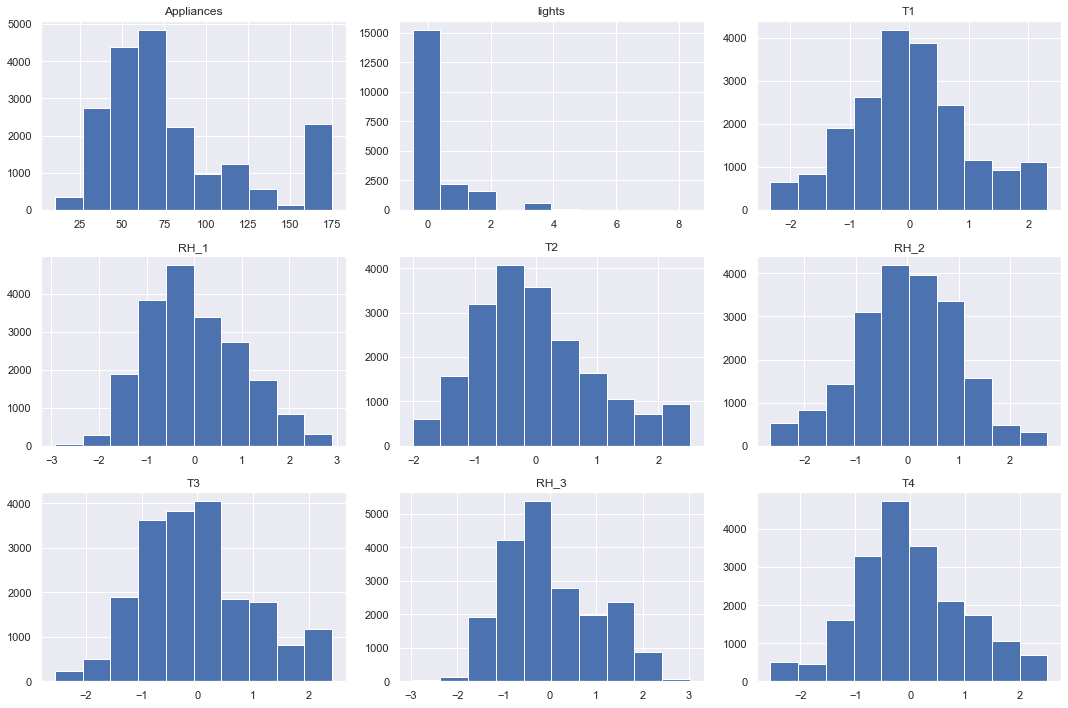

In [93]:
hist_individual(dtProcessado_IQR_padronizado, quantitativas[0:9])

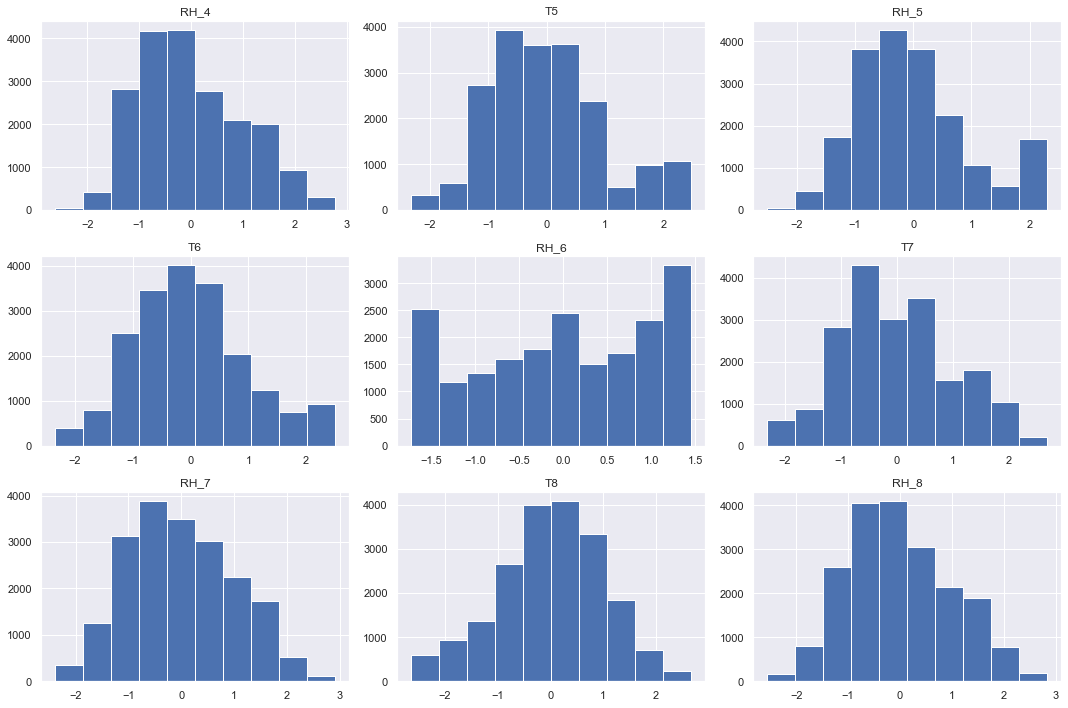

In [94]:
hist_individual(dtProcessado_IQR_padronizado, quantitativas[9:18])

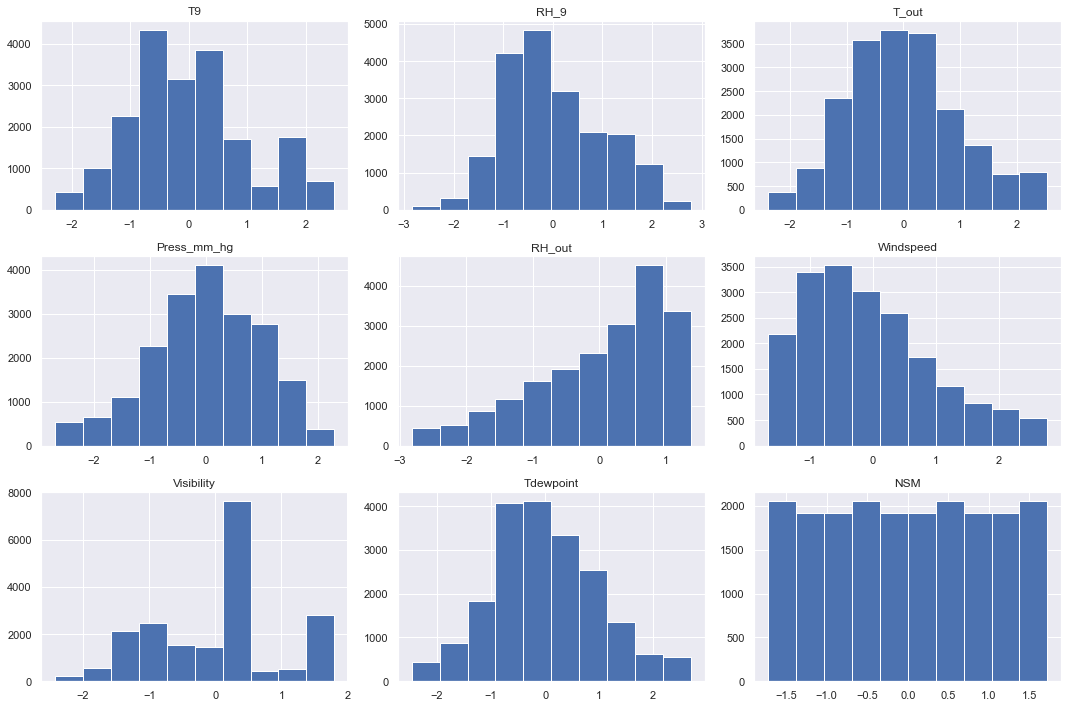

In [95]:
hist_individual(dtProcessado_IQR_padronizado, quantitativas[18:27])

Já em relação aos outliers, com a aplicação de IR e correçõs nas escalas dos dados conseguimos uma redução perceptivel.

Observação: Não foi aplicado correção de outliers por IQR na variavel 'lights'.

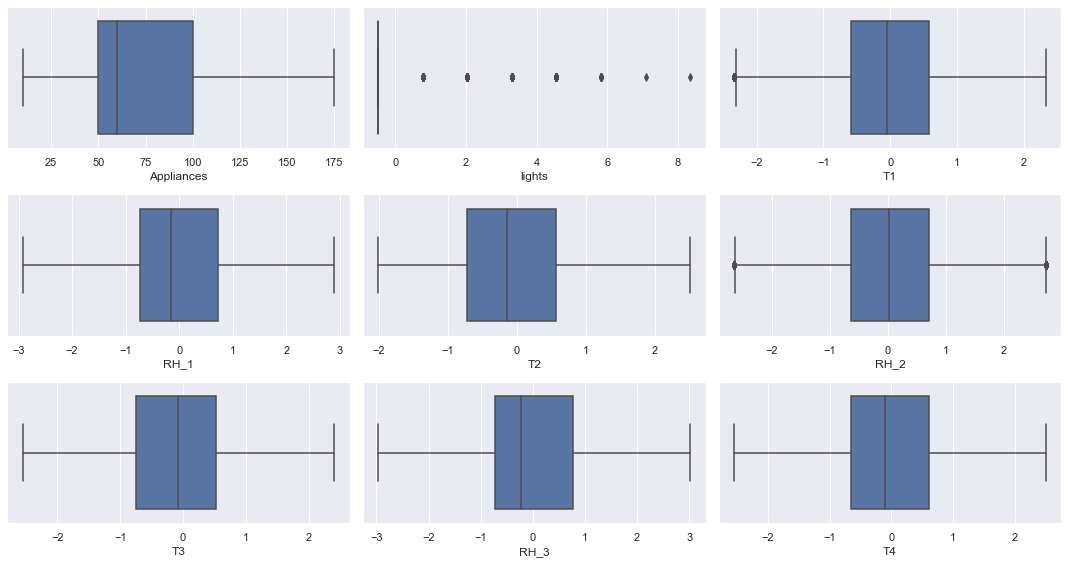

In [96]:
boxplot_individuais(dtProcessado_IQR_padronizado, quantitativas[0:9])

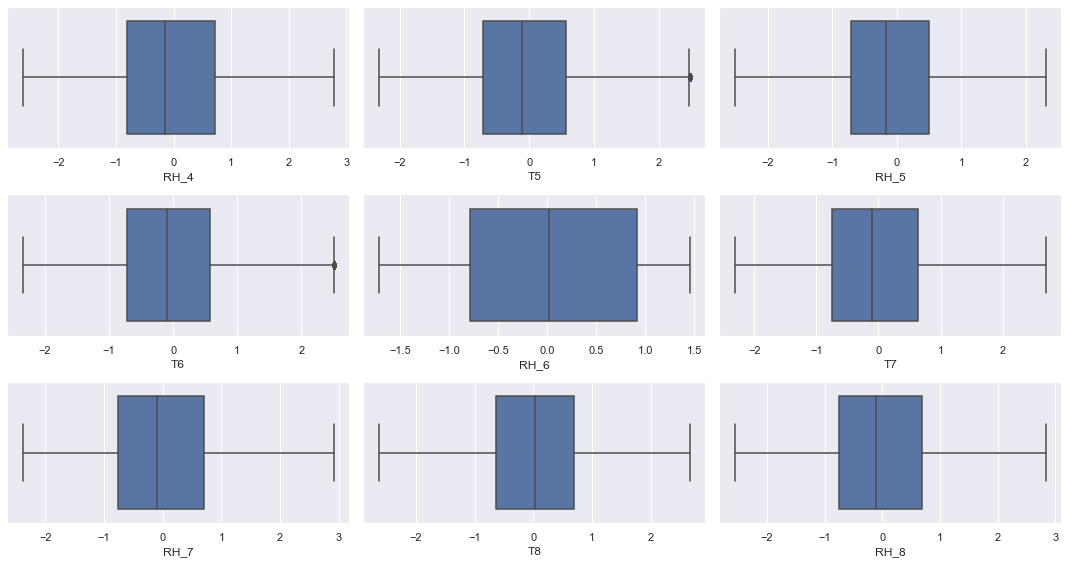

In [97]:
boxplot_individuais(dtProcessado_IQR_padronizado, quantitativas[9:18])

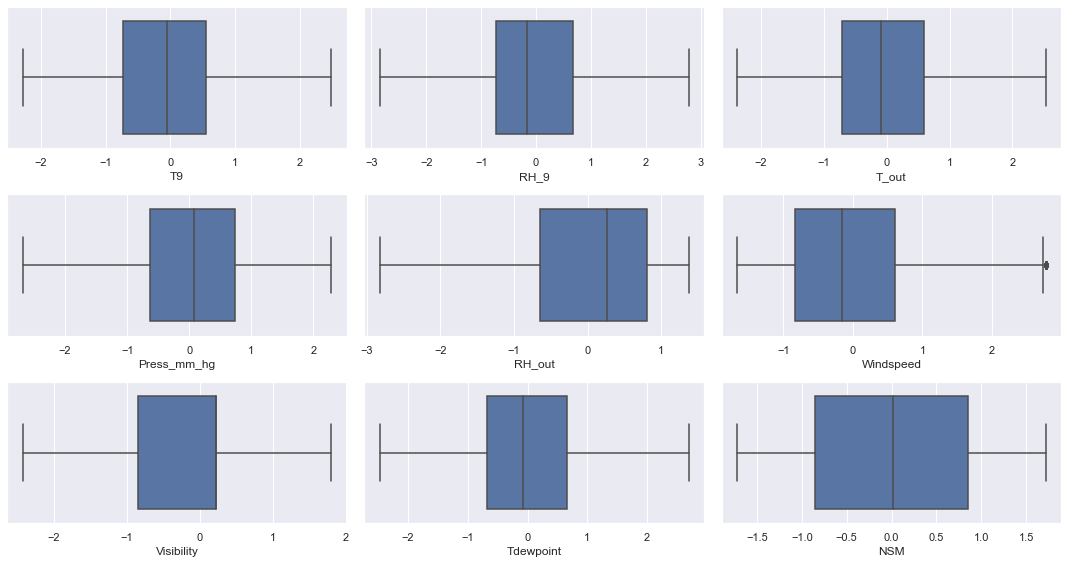

In [98]:
boxplot_individuais(dtProcessado_IQR_padronizado, quantitativas[18:27])

## 5.5 Incremento nas Features

Aqui iremos acrescentar mais uma variavel no nosso dataset que irá merecer uma analise na etapa de Feature Selection. Iremos acrescentar uma Feature do tipo booleana para os feriados no de coleta dos dados.

In [99]:
feriados = []

# Criando lista com todos feriados do ano em que o dataset foi gerado
for data in Belgium(years = [2016]).items():
    feriados.append(data)

In [100]:
# Converter para dataframe e renomear colunas
dtferiados = pd.DataFrame(feriados)
dtferiados.columns = ['data', 'feriado']

In [101]:
dtferiados.head()

data            feriado
0  2016-01-01      Nieuwjaarsdag
1  2016-03-27              Pasen
2  2016-03-28        Paasmaandag
3  2016-05-05  O.L.H. Hemelvaart
4  2016-05-15         Pinksteren

In [102]:
# Criar uma copia do dataset original para recuperar a coluna 'date', desconsiderando horario
dtTemp = dtFull.copy()
dtTemp['date'] = pd.to_datetime(dtTemp['date'], format='%Y-%m-%d %H:%M:%S').dt.date

In [103]:
def isHoliday(row):
    
    # Verifica se a data da linha atual esta no dataframe de feriados
    holiday = dtferiados.apply(lambda x: 1 if (row['date'] == x['data']) else 0, axis = 1)
    
    holiday = sum(holiday)
    
    if holiday > 0:
        holiday = 1
    else:
        holiday = 0
    
    return holiday

In [104]:
# Preenche a coluna feriados do dataframe temporario
dtTemp['Holiday'] = dtTemp.apply(isHoliday, axis = 1)

In [105]:
# Copia a coluna de feriados do dataframe temporario para o novo
dtProcessado_incremento = dtProcessado_IQR_padronizado.copy()
dtProcessado_incremento['Holiday'] = dtTemp['Holiday'].copy().values

Como verificado abaixo criamos uma variavel boolean para os dias que forem feriado, onde pode ocorrer um aumento do consumo de energia. 

In [106]:
dtProcessado_incremento.head()

Appliances    lights        T1      RH_1        T2      RH_2        T3  \
0        60.0  3.301264 -1.139072  1.863478 -0.528718  1.092582 -1.245155   
1        60.0  3.301264 -1.139072  1.634348 -0.528718  1.075633 -1.245155   
2        50.0  3.301264 -1.139072  1.534580 -0.528718  1.051570 -1.245155   
3        60.0  4.561378 -1.139072  1.543034 -0.528718  1.027297 -1.245155   
4        50.0  4.561378 -1.139072  1.465249 -0.528718  1.019764 -1.245155   

       RH_3        T4      RH_4  ...  Windspeed  Visibility  Tdewpoint  \
0  1.686863 -0.912635  1.506438  ...   1.226233    1.799947   0.367016   
1  1.705307 -0.912635  1.604528  ...   1.088599    1.799947   0.343175   
2  1.749367 -0.948663  1.580918  ...   0.950965    1.687977   0.319333   
3  1.769859 -0.966677  1.497991  ...   0.675697    0.952175   0.271649   
4  1.749367 -0.966677  1.544061  ...   0.538063    0.584273   0.247807   

        NSM  Weekend  Day_of_week  Month  Day  Hour  Holiday  
0  0.733493        0            0      1   11    17        0  
1  0.757551        0            0      1   11    17        0  
2  0.781610        0            0      1   11    17        0  
3  0.829726        0            0      1   11    17        0  
4  0.853785        0            0      1   11    17        0  

[5 rows x 33 columns]

Por ultimo iremos remover a variavel 'lights' por não fazer sentido estar no modelo, visto que a mesma apresenta o consumo de Wh das fontes luz da residencia, assim nos indicando um pouco do consumo de energia.

In [107]:
dtFinal = dtProcessado_incremento.drop('lights', axis = 1)

# 6. Feature Selecting

Após uma densa etapa de analise exploratoria e pre-processamento iremos iniciar a etapa de seleção de variaveis, onde iremos ter que trabalhar densamente para eliminar multicolinearidade escolher variaveis que trazem valor para o nosso problema.

Sobre a regressão Lasso e Ridge, iremos utilizar a Lasso com uma das alternativas para medir a importancia das variaveis. Já a ressão Ridge, iremos utilizar durante a modelagem preditiva para tentar aumentar a importancia das variaveis corretas.

In [108]:
dtFinal.columns

Index(['Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4',
       'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',
       'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'NSM', 'Weekend', 'Day_of_week', 'Month', 'Day', 'Hour',
       'Holiday'],
      dtype='object')

## 6.1 Select From Model - Random Forest

Iremos utilizar o SelectModel para secionarmos as variaveis baseadas em sua importância, posteriormente iremos realizar o plot de importância por variavel.

In [109]:
X_fs = dtFinal.drop(['Appliances'], axis = 1)
y_fs = dtFinal['Appliances'].values

In [110]:
seleciona_fs = SelectFromModel(RandomForestRegressor())
seleciona_fs.fit(X_fs, y_fs)

SelectFromModel(estimator=RandomForestRegressor())

In [111]:
variaveis = X_fs.columns[seleciona_fs.get_support()]

In [112]:
print(variaveis)

Index(['T3', 'RH_3', 'T8', 'Press_mm_hg', 'NSM', 'Hour'], dtype='object')


## 6.2 Random Forest - Feature Importance

Agora iremos utilizar o Random Forest na sua forma pura, sem hiperparametros. Essa forma é um pouco perigosa pois pode gerar vies do modelo, por isso iremos testar posteriormente com um modelo diferente.

In [113]:
modelo_fs_v1 = RandomForestRegressor()
modelo_fs_v1.fit(X_fs, y_fs)

RandomForestRegressor()

In [114]:
index_ordenado_fs_v1 = modelo_fs_v1.feature_importances_.argsort()

Analisando, possuimos a variavel 'NSM' com a maior importancia muito a frente, seguido por 'Hour' e 'Lights'. O SelectModel analisou que as melhores variaveis seriam as: 'lights', 'T3', 'RH_3', 'T8', 'Press_mm_hg', 'NSM' e 'Hour'.

Dessa forma escolhendo as 7 variaveis com maior importancia.

<BarContainer object of 31 artists>

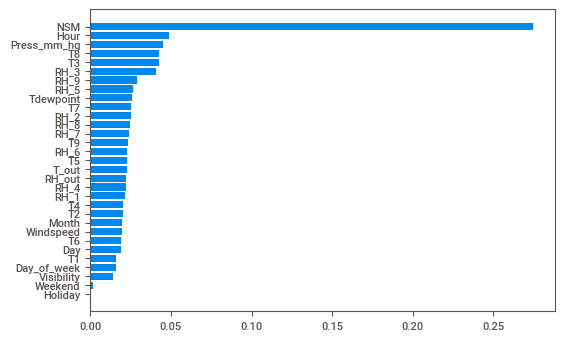

In [115]:
plt.barh(dtFinal.drop(['Appliances'], axis = 1).columns[index_ordenado_fs_v1],\
         modelo_fs_v1.feature_importances_[index_ordenado_fs_v1])

## 6.3 Regressão LASSO

Iremos utilizar a Regressão LASSO para minimizar variaveis, assim podemos diminuir a nossa dimensionalidade e multicolinearidade, de forma que o modelo se torne mais generalizado.

In [116]:
# Função para calcular o RMSE
def rmse_cv(modelo, x, y):
    rmse = np.sqrt(-cross_val_score(modelo, 
                                    x, 
                                    y, 
                                    scoring = "neg_mean_squared_error", 
                                    cv = 5))
    return(rmse)

In [117]:
# Criando modelo LASSO, com lista de alphas e executanndo em CV
modelo_fs_v2 = LassoCV(alphas = [10, 1, 0.1, 0.01, 0.001])
modelo_fs_v2.fit(X_fs, y_fs)

C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4357.590548660606, tolerance: 2759.9261819103117
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3480847.6415894013, tolerance: 2759.9261819103117
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76205.56021223217, tolerance: 2889.6108006080567
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526

LassoCV(alphas=[10, 1, 0.1, 0.01, 0.001])

In [118]:
# Calculando RMSE de todos os CV
rmse = rmse_cv(modelo_fs_v2, X_fs, y_fs)

C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60265.489504825324, tolerance: 2121.555612826604
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3449080.197078473, tolerance: 2121.555612826604
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2848743.487422847, tolerance: 2242.5050556215356
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

In [119]:
# Print valor medio, maximo, minimo
print(rmse.mean(), max(rmse), min(rmse))

37.20205195968503 41.53525490236213 34.49627699946396


In [120]:
# Coeficientes LASSO
coef = pd.Series(modelo_fs_v2.coef_, index = X_fs.columns)

In [121]:
coef.sort_values().tail(15)

Day_of_week     0.478850
Visibility      0.485754
RH_5            0.613386
RH_6            0.798299
Hour            0.892201
Holiday         1.213774
RH_out          2.117558
Weekend         2.243103
Windspeed       2.301194
T4              2.349132
RH_3            3.780797
T8             12.106176
T6             17.054270
T3             20.129085
RH_1           26.180667
dtype: float64

Text(0.5, 1.0, 'Coeficientes Modelo LASSO')

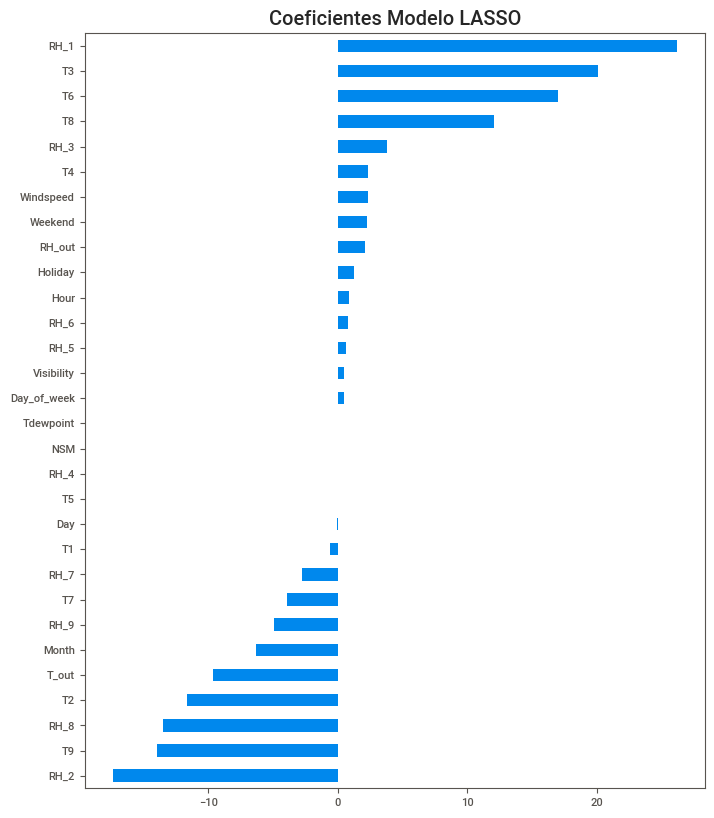

In [122]:
# Plotando importancia das variaveis
imp_coef_fs = pd.concat([coef.sort_values().head(15), coef.sort_values().tail(15)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_fs.plot(kind = "barh")
plt.title("Coeficientes Modelo LASSO")

## 6.4 Recursive Feature Elimination (RFE) - Linear SVR

Como quarto metodo, iremos utilizar RFE, onde em geral apresenta bons resultados para combater multicolinearidade que é o nosso principal problema nesse dataset. Porém, o seu tempo de execução pode ser muito grande.

In [123]:
# Criando modelo de SVM para regressão
modelo_v4 = LinearSVR(max_iter = 3000)
rfe = RFE(modelo_v4, n_features_to_select = 8)

In [124]:
# Treinando RFE
rfe.fit(X_fs, y_fs)

RFE(estimator=LinearSVR(max_iter=3000), n_features_to_select=8)

In [125]:
print('Features Selecionadas: %s' % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

Features Selecionadas: [ True  True False  True  True False False False False False False False
  True False  True  True  True False False False False False False False
 False False False False False False False]
Feature Ranking: [ 1  1  2  1  1 16 13 20 17 15  3 19  1 12  1  1  1  7 18 24  9 10 21  8
  4 23 14  6 22  5 11]


In [126]:
variaveis_v4 = [X_fs.columns[i] for i, col in enumerate(rfe.support_) if col == True]

In [127]:
print(variaveis_v4)

['T1', 'RH_1', 'RH_2', 'T3', 'T7', 'T8', 'RH_8', 'T9']


In [128]:
X_fs[variaveis_v4].head()

T1      RH_1      RH_2        T3        T7        T8      RH_8  \
0 -1.139072  1.863478  1.092582 -1.245155 -1.453651 -1.961010  1.142031   
1 -1.139072  1.634348  1.075633 -1.245155 -1.453651 -1.961010  1.135010   
2 -1.139072  1.534580  1.051570 -1.245155 -1.453651 -1.961010  1.109480   
3 -1.139072  1.543034  1.027297 -1.245155 -1.453651 -2.012209  1.082673   
4 -1.139072  1.465249  1.019764 -1.245155 -1.485247 -2.012209  1.082673   

         T9  
0 -1.217324  
1 -1.200778  
2 -1.233869  
3 -1.233869  
4 -1.233869

## 6.5 Analisando Seleção

In [129]:
def avalia_modelo(modelo, x, y):  
    preds = modelo.predict(x)
    
    erros = abs(preds - y)
    mape = 100 * np.mean(erros / y)
    r2 = 100*r2_score(y, preds)
    acuracia = 100 - mape
    mse = mean_squared_error(y, preds, squared = True)
    mae = mean_absolute_error(y, preds)
    rmse = mean_squared_error(y, preds, squared = False)
    
    print(modelo,'\n')
    print('R^2                 : {:0.2f}%' .format(r2))
    print('Acuracia            : {:0.2f}%'.format(acuracia))
    print('MAE                 : {:0.2f}'.format(mae))
    print('MSE                 : {:0.2f}'.format(mse))
    print('RMSE                : {:0.2f}\n'.format(rmse))

### 6.5.1 Random Forest

In [130]:
# Selecionando variaveis do RandomForestRegressor
X_sel_fs_v1 = X_fs[variaveis]

In [131]:
x_train, x_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size = .3, random_state = seed_)

Primeiramente iremos avaliar o modelo com todas as variaveis utilizadas durante a sua construção.

In [132]:
# Criando o modelo com todas variaveis
modelo_sel_fs_v1 = RandomForestRegressor()
modelo_sel_fs_v1.fit(x_train, y_train)

RandomForestRegressor()

In [133]:
avalia_modelo(modelo_sel_fs_v1, x_test, y_test)

RandomForestRegressor() 

R^2                 : 73.77%
Acuracia            : 79.46%
MAE                 : 14.20
MSE                 : 476.38
RMSE                : 21.83



In [134]:
x_train, x_test, y_train, y_test = train_test_split(X_sel_fs_v1, y_fs, test_size = .3, random_state = seed_)

In [135]:
# Criando o modelo com variaveis selecionodas pelo RandomForestRegressor
modelo_sel_fs_v2 = RandomForestRegressor()
modelo_sel_fs_v2.fit(x_train, y_train)

RandomForestRegressor()

Avaliando o modelo utilizando somente 6 colunas, mantivemos um R^2 de 70% com um aumento para 23 do RMSE. Apesar do modelo ser um pouco pior, aumentamos a nossa generalização em muito, visto que passamos de 31 variaveis para 6 variaveis.

In [136]:
avalia_modelo(modelo_sel_fs_v2, x_test, y_test)

RandomForestRegressor() 

R^2                 : 70.37%
Acuracia            : 78.15%
MAE                 : 15.21
MSE                 : 538.10
RMSE                : 23.20



In [137]:
i = 20
x_temp = x_test.iloc[i]
x_temp = pd.DataFrame(x_temp).T
y_temp = y_test[i]

In [138]:
pred = modelo_sel_fs_v2.predict(x_temp)

In [139]:
print('Previsto:', pred,'Real:', y_temp)

Previsto: [49.1] Real: 50.0


### 6.5.2 LASSO

In [140]:
X_sel_fs_v2 = X_fs[['RH_1', 'T3', 'T6', 'T8', 'RH_3']]

In [141]:
x_train, x_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size = .3, random_state = seed_)

Primeiramente iremos avaliar o modelo com todas as variaveis utilizadas durante a sua construção.

In [142]:
# Criando modelo LASSO, com todas variaveis
modelo_sel_fs_v3 = LassoCV(alphas = [10, 1, 0.1, 0.01, 0.001])
modelo_sel_fs_v3.fit(x_train, y_train)

C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548945.3283650819, tolerance: 2054.5656972219717
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2613726.3627101686, tolerance: 2033.1613442222433
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098964.046488886, tolerance: 2076.477421952764
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\herik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

LassoCV(alphas=[10, 1, 0.1, 0.01, 0.001])

In [143]:
avalia_modelo(modelo_sel_fs_v3, x_test, y_test)

LassoCV(alphas=[10, 1, 0.1, 0.01, 0.001]) 

R^2                 : 27.09%
Acuracia            : 59.58%
MAE                 : 26.93
MSE                 : 1323.89
RMSE                : 36.39



In [144]:
x_train, x_test, y_train, y_test = train_test_split(X_sel_fs_v2, y_fs, test_size = .3, random_state = seed_)

In [145]:
# Criando modelo LASSO, com variaveis selecionadas
modelo_sel_fs_v4 = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
modelo_sel_fs_v4.fit(x_train, y_train)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005])

Analisando o modelo é perceptivel que ele não conseguiu representar os dados da forma adequada, mantendo um R^2 abaixo de 50%, com acuracia pouco acima de 50%.

In [146]:
avalia_modelo(modelo_sel_fs_v4, x_test, y_test)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005]) 

R^2                 : 4.52%
Acuracia            : 51.10%
MAE                 : 32.33
MSE                 : 1733.83
RMSE                : 41.64



### 6.5.3 RFE - Linear SVR

In [147]:
# Selecionando variaveis do RandomForestRegressor
X_sel_fs_v3 = X_fs[variaveis_v4]

In [148]:
x_train, x_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size = .3, random_state = seed_)

In [149]:
# Criando o modelo com todas variaveis
modelo_sel_fs_v3 = LinearSVR(max_iter = 3000)
modelo_sel_fs_v3.fit(x_train, y_train)

LinearSVR(max_iter=3000)

Analisando o modelo com todas variaveis, o deu desempenho não aparenta ser bom visto que manteve um R^2 abaixo de 50% e alto RMSE, apesar disso apresentou uma acuracia superior ao modelo de regressão LASSO.

In [150]:
avalia_modelo(modelo_sel_fs_v3, x_test, y_test)

LinearSVR(max_iter=3000) 

R^2                 : 20.54%
Acuracia            : 67.07%
MAE                 : 25.50
MSE                 : 1442.97
RMSE                : 37.99



In [151]:
x_train, x_test, y_train, y_test = train_test_split(X_sel_fs_v3, y_fs, test_size = .3, random_state = seed_)

In [152]:
# Criando o modelo com todas variaveis
modelo_sel_fs_v3 = LinearSVR(max_iter = 3000)
modelo_sel_fs_v3.fit(x_train, y_train)

LinearSVR(max_iter=3000)

In [153]:
avalia_modelo(modelo_sel_fs_v3, x_test, y_test)

LinearSVR(max_iter=3000) 

R^2                 : 17.33%
Acuracia            : 66.91%
MAE                 : 25.96
MSE                 : 1501.27
RMSE                : 38.75



Realizando a analise acima é perceptivel que as variaveis que aparentam trazer mais representatividade para o nosso modelo são as do modelo de Random Forest, esse que sugeriu utilizar as seguintes variaveis:

'T3', 'RH_3', 'T8', 'Press_mm_hg', 'NSM' e 'Hour'

Analisando as variaveis acima:
'T3' -> Mede a temperatura em graus celsius na lavanderia, a lavanderia constuma possuir equipamentos que consomem um nivel de energia significativamente maior do que outros eletrodomesticos, assim também aumenta o nivel de calor no comodo.

'RH_3' -> Umidade relativa na lavanderia, indicando aumento da umidade no ambiente, também por conta dos eletrodomesticos utilizados no ambiente.

'T8' -> Temperatura no quarto do adolescente.

'Press_mm_hg' -> Pressão.

'NSM' -> Quantos segundos faltam para a meia noite, visto que quando mais proximo da meia noite menor o consumo de energia.

'Hour' -> Semelhante a 'NSM' porém indicando a forma do dia de forma mais especifica, visto que a hora influencia diretamente no consumo de energia.

# 7. Modelagem Preditiva

## 7.1 Definindo Ambiente

In [109]:
# Separando em variaveis preditivas e target 
#X = dtFinal[variaveis]
X = dtFinal[['T3', 'RH_3', 'T8', 'Press_mm_hg', 'NSM', 'Hour']]
y = dtFinal['Appliances'].values

In [110]:
X.head()

T3      RH_3        T8  Press_mm_hg       NSM  Hour
0 -1.245155  1.686863 -1.961010    -2.684267  0.733493    17
1 -1.245155  1.705307 -1.961010    -2.684267  0.757551    17
2 -1.245155  1.749367 -1.961010    -2.684267  0.781610    17
3 -1.245155  1.769859 -2.012209    -2.684267  0.829726    17
4 -1.245155  1.749367 -2.012209    -2.684267  0.853785    17

In [111]:
y

array([ 60.,  60.,  50., ..., 100., 100., 175.])

In [112]:
# Separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed_)

In [113]:
def reportModeloRegressao(modelo, x_teste, y_teste, x_treino = [], y_treino = [], report_treino = False):  
    y_pred = modelo.predict(x_teste)
    
    erros = abs(y_pred - y_teste)
    mape = 100 * np.mean(erros / y_teste)
    r2 = 100*r2_score(y_teste, y_pred)
    r2_ajustado = 1 - (1 - r2) * (len(y_teste) - 1) / (len(y_teste) - x_teste.shape[1] -1)
    acuracia = 100 - mape
    mse = mean_squared_error(y_teste, y_pred, squared = True)
    mae = mean_absolute_error(y_teste, y_pred)
    rmse = mean_squared_error(y_teste, y_pred, squared = False)
    
    print(modelo,'\n')
    print('Dados de teste')
    print('R^2                 : {:0.2f}%' .format(r2))
    print('R^2 Ajustado        : {:0.2f}%' .format(r2_ajustado))
    print('Acuracia            : {:0.2f}%'.format(acuracia))
    print('MAE                 : {:0.2f}'.format(mae))
    print('MSE                 : {:0.2f}'.format(mse))
    print('RMSE                : {:0.2f}\n'.format(rmse))
    
    residuo = abs(y_teste - y_pred)
    plt.scatter(residuo, y_pred)
    plt.xlabel('Residuos')
    plt.ylabel('Previsto')
    plt.show()
    
    if report_treino:
        print('Dados de treino')
        if x_treino.shape[1] > 0 and len(y_treino) > 0: 
            reportModeloRegressao(modelo, x_treino, y_treino)
        else:
            print('X_treino e/ou y_treino possuem tamanho 0.')

In [114]:
def treinaRegressao_GridSearchCV(modelo, params_, x_treino, y_treino, x_teste, y_teste,\
                        n_jobs = -1, cv = 5, refit = True, scoring = None, salvar_resultados = False,\
                       report_treino = False):
    grid = GridSearchCV(modelo, params_, n_jobs = n_jobs, cv = cv, refit = refit, scoring = scoring)
    
    grid.fit(x_treino, y_treino)
    pred = grid.predict(x_teste)
    modelo_ = grid.best_estimator_

    print(grid.best_params_)
    
    reportModeloRegressao(modelo_, x_teste, y_teste, x_treino, y_treino, report_treino) 
    
    if salvar_resultados:
        resultados_df = pd.DataFrame(grid.cv_results_)
        
        return resultados_df 

## 7.2 SVR

Primeiramente iremos criar um modelo base utilizando o algoritmo SVM para regressão, conhecido como SVR. Assim, iremos poder ter uma metrica minima para comparar os nossos modelos, posteriormente iremos passar por uma fase de tuning dos hiperparametros, utilizaando GridSearchCV e depois um tuning manual.

In [115]:
# Modelo base do algoritmo SVM para regressão
modelo_svr = SVR(max_iter = -1)
modelo_svr.fit(x_train, y_train)

SVR()

Apesar da nossa acuracia base ser 67%, estamos com um R^2 muito baixo de apenas 20.75%. Iremos tentar diminuor o nosso RMSE na medida que aumentamos o R^2.

SVR() 

Dados de teste
R^2                 : 20.75%
R^2 Ajustado        : 20.77%
Acuracia            : 67.23%
MAE                 : 25.13
MSE                 : 1439.09
RMSE                : 37.94



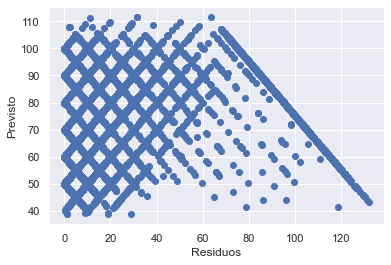

Dados de treino
SVR() 

Dados de teste
R^2                 : 20.72%
R^2 Ajustado        : 20.72%
Acuracia            : 67.57%
MAE                 : 25.55
MSE                 : 1473.20
RMSE                : 38.38



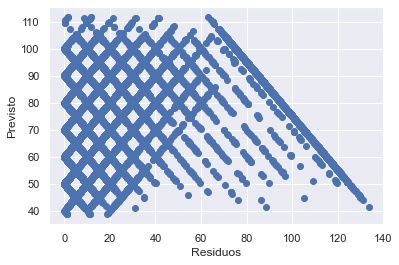

In [116]:
reportModeloRegressao(modelo_svr, x_test, y_test, x_train, y_train, True)

{'C': 1.1, 'gamma': 'auto', 'kernel': 'rbf'}
SVR(C=1.1, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 29.20%
R^2 Ajustado        : 29.23%
Acuracia            : 70.64%
MAE                 : 22.95
MSE                 : 1285.61
RMSE                : 35.86



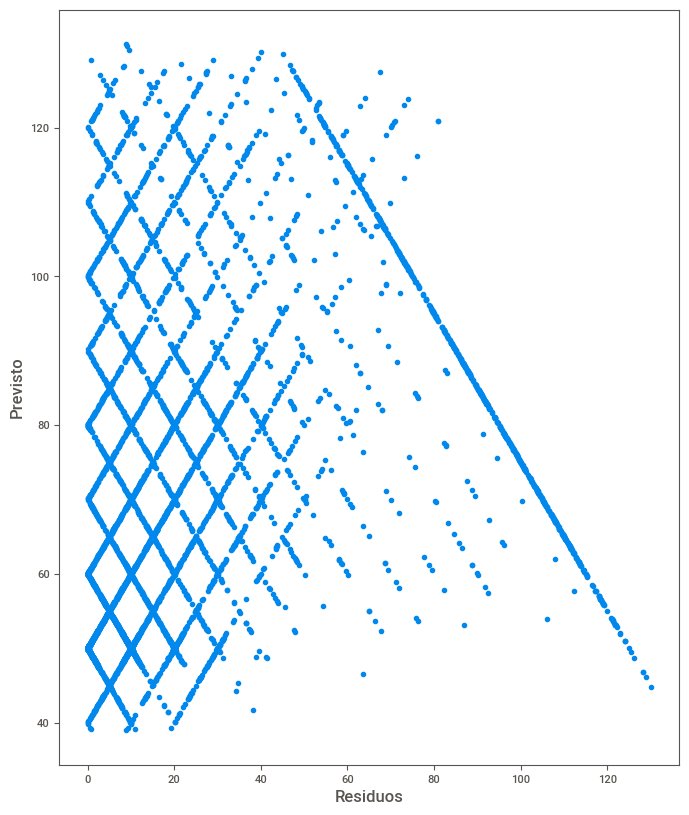

Dados de treino
SVR(C=1.1, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 29.90%
R^2 Ajustado        : 29.92%
Acuracia            : 71.75%
MAE                 : 22.92
MSE                 : 1302.48
RMSE                : 36.09



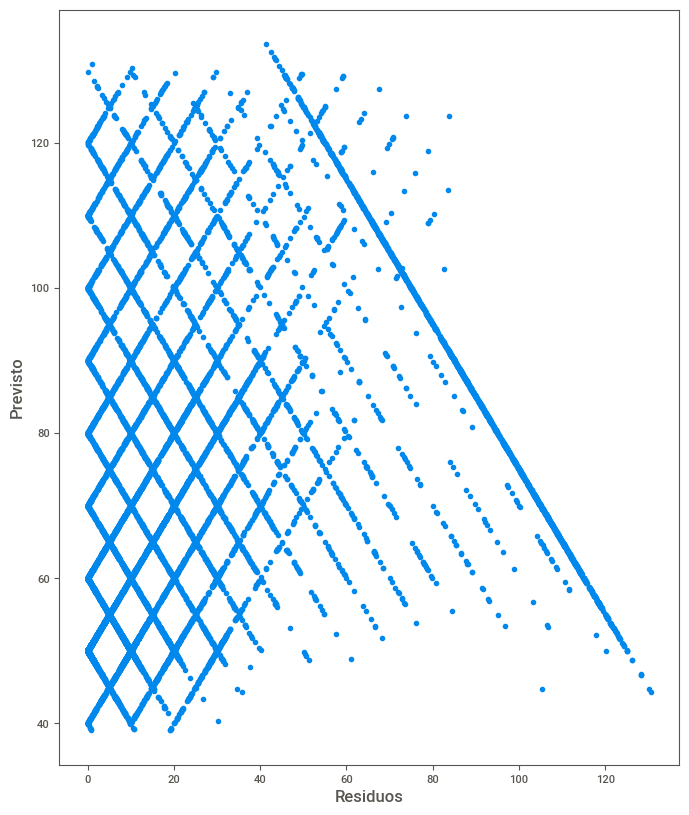

Wall time: 4min 59s


In [162]:
%%time

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.9, 1.0, 1.1],
    'gamma': ['scale', 'auto']
}

# Criação de modelo intenso 01
modelo = SVR(max_iter = -1, cache_size = 1000)
treinaRegressao_GridSearchCV(modelo, params, x_train, y_train, x_test, y_test, scoring = 'neg_root_mean_squared_error',\
                            report_treino = True)

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
SVR(C=100, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 42.47%
R^2 Ajustado        : 42.51%
Acuracia            : 72.61%
MAE                 : 20.77
MSE                 : 1044.65
RMSE                : 32.32



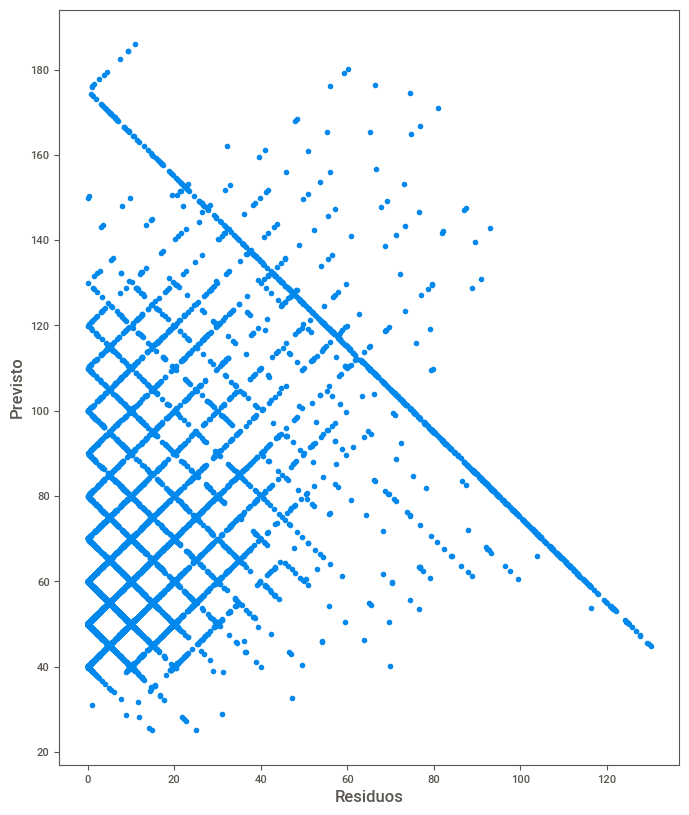

Dados de treino
SVR(C=100, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 45.52%
R^2 Ajustado        : 45.54%
Acuracia            : 74.85%
MAE                 : 19.83
MSE                 : 1012.21
RMSE                : 31.82



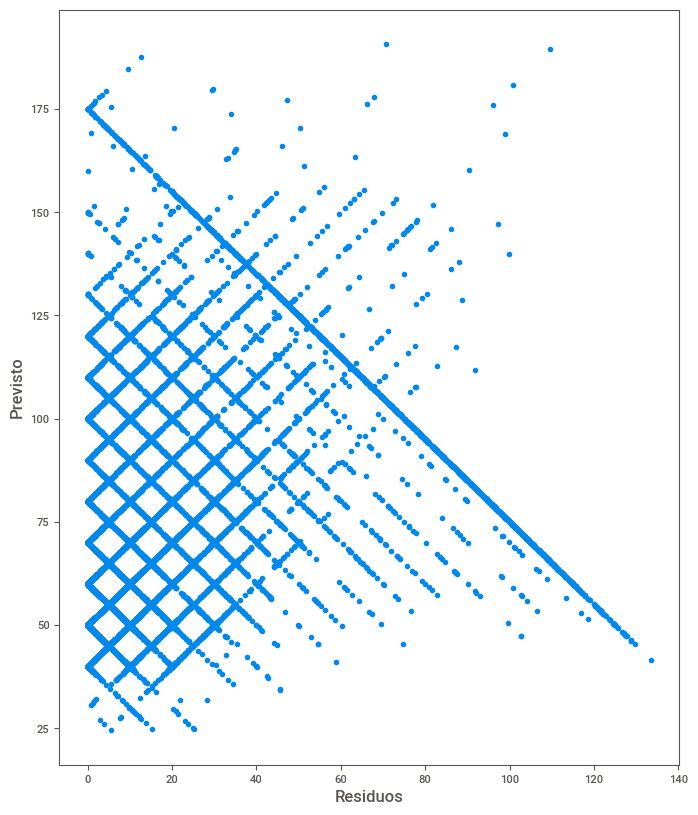

Wall time: 4min 21s


In [163]:
%%time

params = {
    'kernel': ['rbf'],
    'C': [0.001, 0.1, 1.0, 10, 100],
    'gamma': ['auto']
}

# Criação de modelo intenso 02
modelo = SVR(max_iter = -1, cache_size = 1000)
treinaRegressao_GridSearchCV(modelo, params, x_train, y_train, x_test, y_test, scoring = 'neg_root_mean_squared_error',\
                            report_treino = True)

{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}
SVR(C=10000, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 51.14%
R^2 Ajustado        : 51.19%
Acuracia            : 74.36%
MAE                 : 18.84
MSE                 : 887.18
RMSE                : 29.79



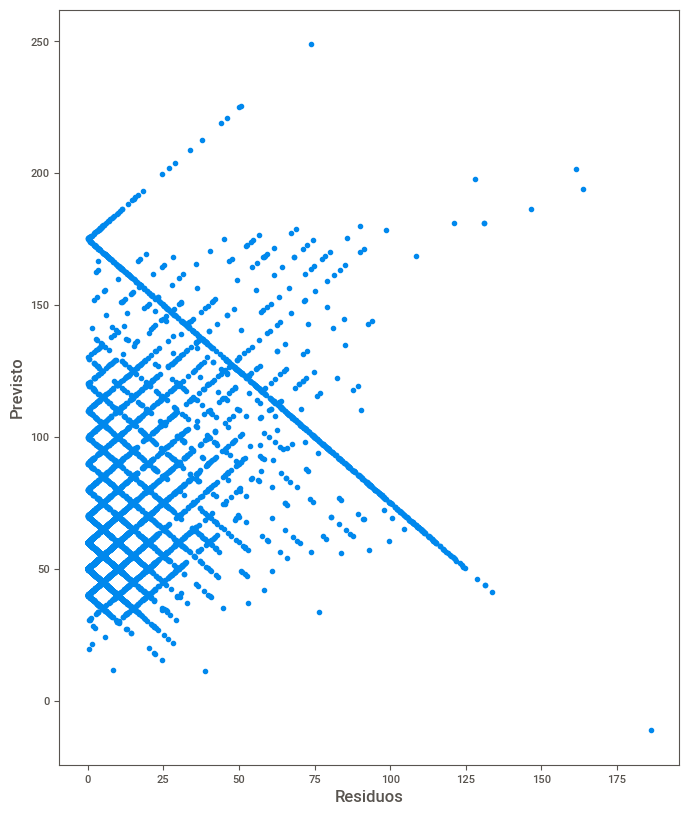

Dados de treino
SVR(C=10000, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 59.99%
R^2 Ajustado        : 60.02%
Acuracia            : 79.48%
MAE                 : 15.77
MSE                 : 743.38
RMSE                : 27.26



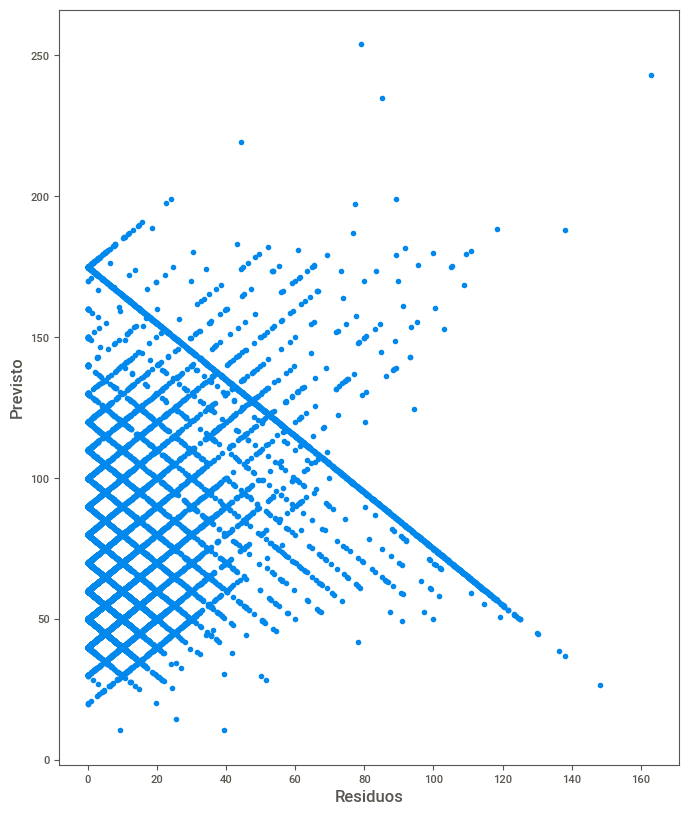

Wall time: 11min 42s


In [164]:
%%time

params = {
    'kernel': ['rbf'],
    'C': [0.1, 1.0, 10, 100, 1000, 10000],
    'gamma': ['auto']
}

# Criação de modelo intenso 03
modelo = SVR(max_iter = -1, cache_size = 1000)
treinaRegressao_GridSearchCV(modelo, params, x_train, y_train, x_test, y_test, scoring = 'neg_root_mean_squared_error',\
                            report_treino = True)

{'C': 2000, 'gamma': 'auto', 'kernel': 'rbf'}
SVR(C=2000, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 48.71%
R^2 Ajustado        : 48.76%
Acuracia            : 73.85%
MAE                 : 19.37
MSE                 : 931.35
RMSE                : 30.52



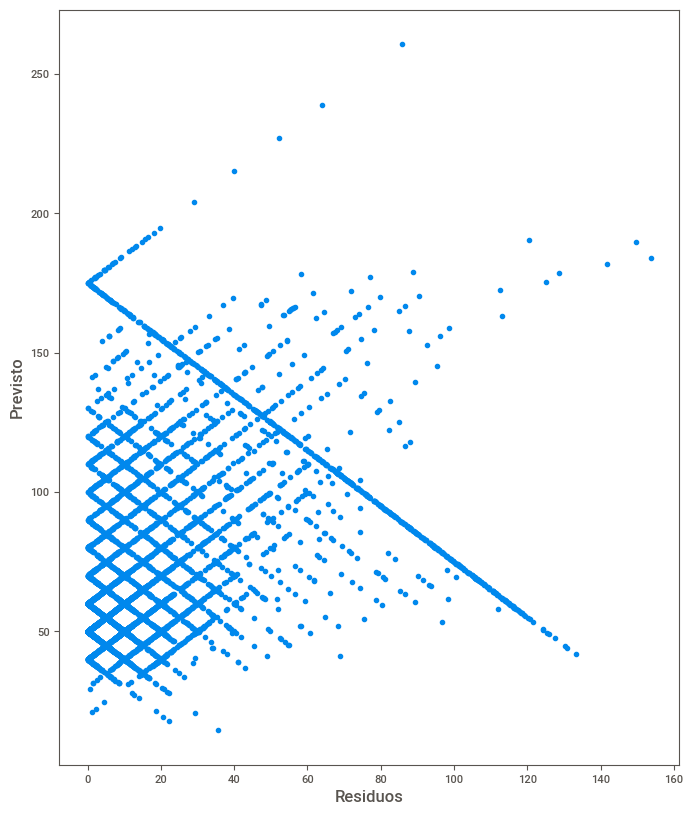

Dados de treino
SVR(C=2000, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 54.99%
R^2 Ajustado        : 55.01%
Acuracia            : 77.76%
MAE                 : 17.20
MSE                 : 836.42
RMSE                : 28.92



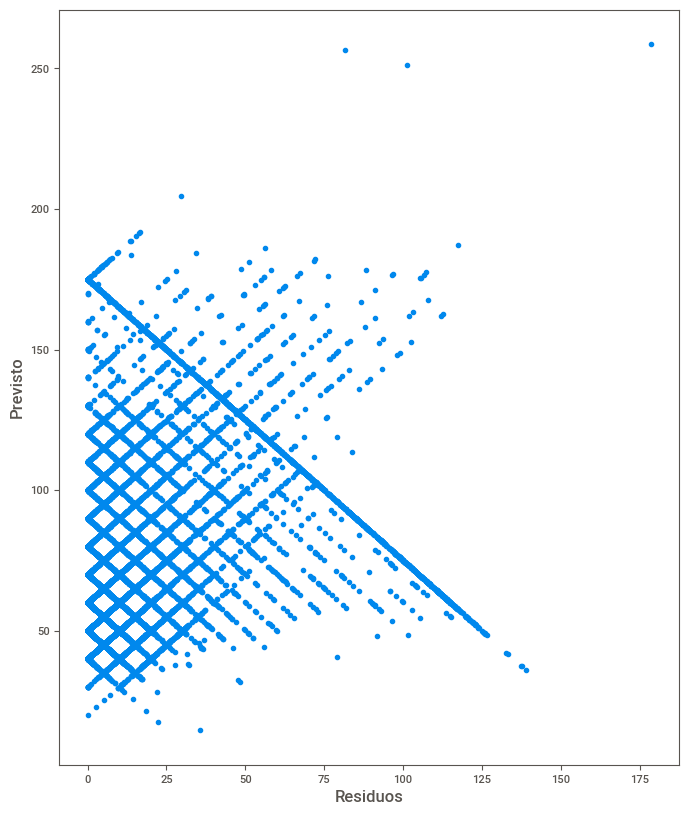

Wall time: 2min 45s


In [165]:
%%time

params = {
    'kernel': ['rbf'],
    'C': [500, 1000, 2000],
    'gamma': ['auto']
}

# Criação de modelo intenso 04
modelo = SVR(max_iter = -1, cache_size = 1000)
treinaRegressao_GridSearchCV(modelo, params, x_train, y_train, x_test, y_test, scoring = 'neg_root_mean_squared_error',\
                            report_treino = True)

SVR(C=10000, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 51.14%
R^2 Ajustado        : 51.19%
Acuracia            : 74.36%
MAE                 : 18.84
MSE                 : 887.18
RMSE                : 29.79



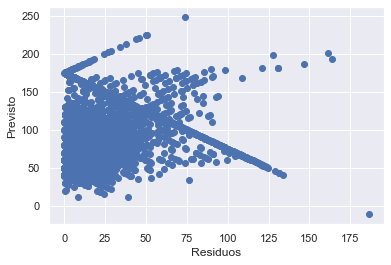

Dados de treino
SVR(C=10000, cache_size=1000, gamma='auto') 

Dados de teste
R^2                 : 59.99%
R^2 Ajustado        : 60.02%
Acuracia            : 79.48%
MAE                 : 15.77
MSE                 : 743.38
RMSE                : 27.26



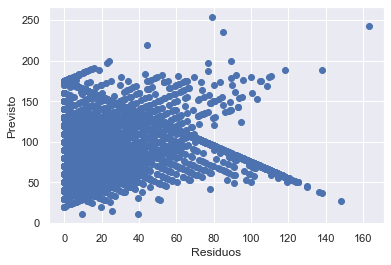

Wall time: 6min 32s


In [117]:
%%time
# Modelo 05
modelo_svr_v5 = SVR(max_iter = -1, cache_size = 1000, kernel = 'rbf', C = 10000, gamma = 'auto')
modelo_svr_v5.fit(x_train, y_train)

reportModeloRegressao(modelo_svr_v5, x_test, y_test, x_train, y_train, True)

SVR(C=10000, cache_size=1000, gamma=1) 

Dados de teste
R^2                 : 56.53%
R^2 Ajustado        : 56.58%
Acuracia            : 76.33%
MAE                 : 17.05
MSE                 : 789.46
RMSE                : 28.10



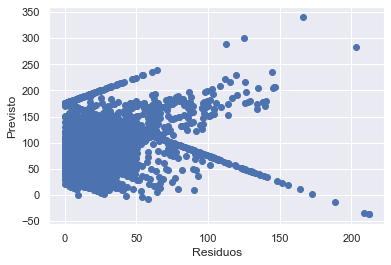

Dados de treino
SVR(C=10000, cache_size=1000, gamma=1) 

Dados de teste
R^2                 : 87.16%
R^2 Ajustado        : 87.20%
Acuracia            : 90.98%
MAE                 : 6.55
MSE                 : 238.58
RMSE                : 15.45



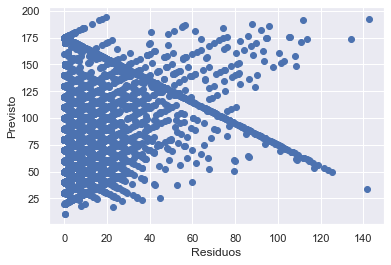

Wall time: 3min 31s


In [124]:
%%time
# Modelo 06
modelo_svr_v6 = SVR(max_iter = -1, cache_size = 1000, kernel = 'rbf', C = 10000, gamma = 1) # gamma = 'auto' = 0.166
modelo_svr_v6.fit(x_train, y_train)

reportModeloRegressao(modelo_svr_v6, x_test, y_test, x_train, y_train, True)

SVR(C=10000, cache_size=1000, gamma=3) 

Dados de teste
R^2                 : 46.41%
R^2 Ajustado        : 46.46%
Acuracia            : 73.57%
MAE                 : 19.00
MSE                 : 973.11
RMSE                : 31.19



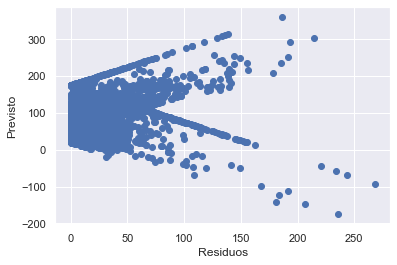

Dados de treino
SVR(C=10000, cache_size=1000, gamma=3) 

Dados de teste
R^2                 : 94.80%
R^2 Ajustado        : 94.84%
Acuracia            : 95.87%
MAE                 : 2.98
MSE                 : 96.68
RMSE                : 9.83



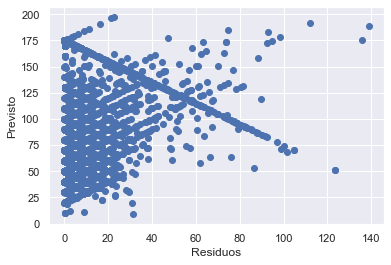

Wall time: 2min 57s


In [126]:
%%time
# Modelo 07
modelo_svr_v7 = SVR(max_iter = -1, cache_size = 1000, kernel = 'rbf', C = 10000, gamma = 3) # gamma = 'auto' = 0.166
modelo_svr_v7.fit(x_train, y_train)

reportModeloRegressao(modelo_svr_v7, x_test, y_test, x_train, y_train, True)

SVR(C=10000, cache_size=1000, gamma=0.5) 

Dados de teste
R^2                 : 56.06%
R^2 Ajustado        : 56.12%
Acuracia            : 76.01%
MAE                 : 17.26
MSE                 : 797.83
RMSE                : 28.25



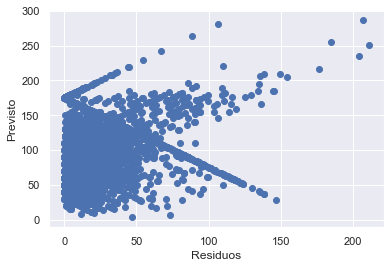

Dados de treino
SVR(C=10000, cache_size=1000, gamma=0.5) 

Dados de teste
R^2                 : 78.26%
R^2 Ajustado        : 78.29%
Acuracia            : 86.84%
MAE                 : 9.83
MSE                 : 404.01
RMSE                : 20.10



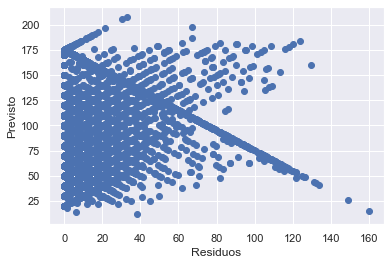

Wall time: 5min 40s


In [127]:
%%time
# Modelo 08
modelo_svr_v8 = SVR(max_iter = -1, cache_size = 1000, kernel = 'rbf', C = 10000, gamma = 0.5) # gamma = 'auto' = 0.166
modelo_svr_v8.fit(x_train, y_train)

reportModeloRegressao(modelo_svr_v8, x_test, y_test, x_train, y_train, True)

### 7.2.1 Conclusão SVR

Executando o algoritmo SVR, conseguimos atingir as seguintes metricas sem evitar overfitting:

R^2                 : 56.06%
R^2 Ajustado        : 56.12%
Acuracia            : 76.01%
MAE                 : 17.26
MSE                 : 797.83
RMSE                : 28.25

Apesar de atingirmos um RMSE relativamente baixo de 28 unidades, não possuimos uma boa acuracia, estando apenas em 75%. Ainda possuimos um R^2 baixo, de apenas 56%.

O algoritmo SVR necessita de uma alta carga de processamento, chegando a possuir testes em que os resultados demoravam mais de 1 hora para serem gerados. Para melhor compreensão foram exibidos nesse documento somente os algoritmos de maior influência.

O algoritmo SVR, não apresentou bom desempenho, devido a alta variabilidade nos dados, que não conseguiram ser identificados da forma ideal. Assim, iremos adotar a eestratégia de utilizar algoritmos ensemble, como XGBoost e CatBoost da categoria boosting.

### 7.2.2 Executando Melhor Modelo

SVR(C=10000, cache_size=1000, gamma=0.5) 

Dados de teste
R^2                 : 56.06%
R^2 Ajustado        : 56.12%
Acuracia            : 76.01%
MAE                 : 17.26
MSE                 : 797.83
RMSE                : 28.25



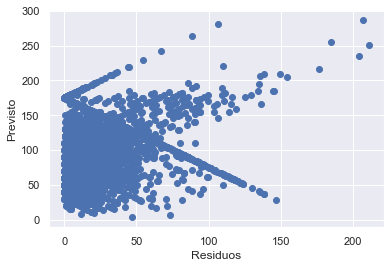

Dados de treino
SVR(C=10000, cache_size=1000, gamma=0.5) 

Dados de teste
R^2                 : 78.26%
R^2 Ajustado        : 78.29%
Acuracia            : 86.84%
MAE                 : 9.83
MSE                 : 404.01
RMSE                : 20.10



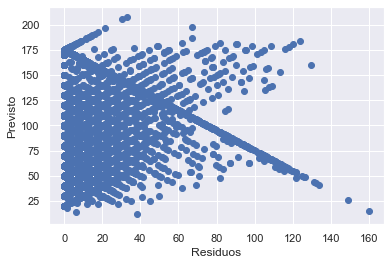

Wall time: 5min 42s


In [129]:
%%time
# Modelo Final
modelo_svr_final = SVR(max_iter = -1, cache_size = 1000, kernel = 'rbf', C = 10000, gamma = 0.5) # gamma = 'auto' = 0.166
modelo_svr_final.fit(x_train, y_train)

reportModeloRegressao(modelo_svr_final, x_test, y_test, x_train, y_train, True)

### 7.2.3 Avaliando SVR

In [154]:
shap.initjs()

In [135]:
# Construindo shap
amostras = 20
explainer = shap.Explainer(modelo_svr_final.predict, x_train)
shap_values = explainer(x_test[:amostras])



Exact explainer:  10%|███████▍                                                                  | 2/20 [00:00<?, ?it/s]

Exact explainer:  20%|█████████████▏                                                    | 4/20 [00:18<00:51,  3.22s/it]

Exact explainer:  25%|████████████████▌                                                 | 5/20 [00:24<01:08,  4.58s/it]

Exact explainer:  30%|███████████████████▊                                              | 6/20 [00:31<01:13,  5.28s/it]

Exact explainer:  35%|███████████████████████                                           | 7/20 [00:37<01:13,  5.69s/it]

Exact explainer:  10%|██████▍                                                         | 10/100 [01:54<21:25, 14.28s/it]


Exact explainer:  45%|█████████████████████████████▋                                    | 9/20 [00:50<01:06,  6.08s/it]

Exact explainer:  50%|████████████████████████████████▌                                | 10/20 [00:56<01:01,  6.13s/it]

Exact explainer:  55%|███████

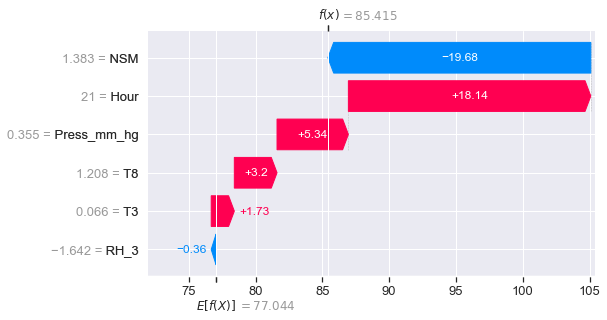

In [149]:
# Waterfall Predição 0
shap.plots.waterfall(shap_values[0])

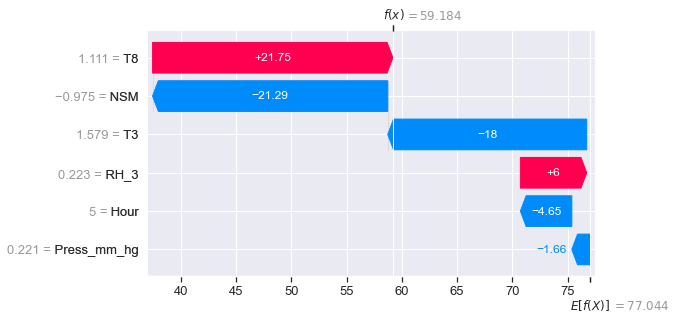

In [152]:
# Waterfall Predição 10
shap.plots.waterfall(shap_values[10])

In [155]:
# Force Predição 0
shap.plots.force(shap_values[0])

In [156]:
# Force Predição 10
shap.plots.force(shap_values[10])

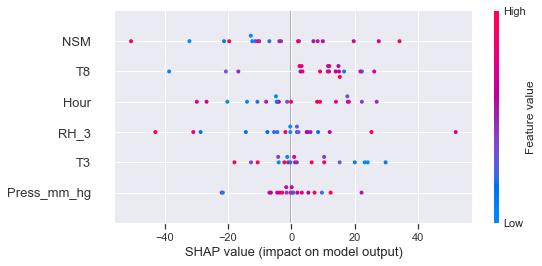

In [188]:
# Summary Plot
shap.summary_plot(shap_values, x_test[:amostras])

In [ ]:
# Force todas predições da amostra
explainer = shap.KernelExplainer(modelo_svr_final.predict, x_train)
shap_values = explainer.shap_values(x_test[:amostras])

Using 13814 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/20 [00:00<?, ?it/s]